# Test modeling on larger synthetic dataset with 300bp
Use 5g sequences but score them simply.

Still try various models
* Linear model
* Kmer count model
* CNN model
* CNN + LSTM model


## ** Classification on balanced randomly generated sequences
* overfit first?

In [1]:
import torch
from torch import nn
from torch.nn import functional as F

import optuna
from optuna.trial import TrialState

import altair as alt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
random.seed(7)
import seaborn as sns

from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler


import utils as u
import torch_utils as tu
from torch_utils import DatasetSpec

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

## Generate Synthetic data

In [3]:
# add synthetic score column
score_dict = {
    'A':20,
    'C':17,
    'G':14,
    'T':11
}

m1 = "CACACA"
m2 = "GTGTGT"

def classify_seqs_motif(seqs):
    data = []
    for locus_tag,seq in seqs:
        seq = seq.strip("N")
        if (m1 in seq and m2 in seq):
            print("both motifs in seq - skipping")
            c = 'skip'
        elif m1 in seq:
            c = 2
        elif m2 in seq:
            c = 1
        else:
            c = 0
        data.append([locus_tag,c])
        
    df = pd.DataFrame(data, columns=['locus_tag','reg'])
    return df

def print_motifs_in_seqs(df, df_name, m1, m2,seq_col='upstream_region'):
    print(df_name)
    seqs = df[seq_col].values

    print(f"{m1}:",len([x for x in seqs if m1 in x]))
    print(f"{m2}:",len([x for x in seqs if m2 in x]))

    print(f"NO {m1}:",len([x for x in seqs if m1 not in x]))
    print(f"NO {m2}:",len([x for x in seqs if m2 not in x]))

    print(f"BOTH:",len([x for x in seqs if (m2 in x and m1 in x)]))
    print(f"NEITHER:",len([x for x in seqs if (m2 not in x and m1 not in x)]))
    
def balance_seqs_for_motifs(seqs, m1, m2,bal=1.0):
    both_seqs = set([x for x in seqs if (m2 in x and m1 in x)])
    m1_seqs = [x for x in seqs if (m1 in x and x not in both_seqs)]
    m2_seqs = [x for x in seqs if (m2 in x and x not in both_seqs)]
    neither = [x for x in seqs if (m2 not in x and m1 not in x)]
    
    print(f"{m1}:",len(m1_seqs))
    print(f"{m2}:",len(m2_seqs))
    print(f"NEITHER: {len(neither)}")
    
    # downselection
    down_select = int(bal*np.mean([len(m1_seqs),len(m2_seqs)]))
    if down_select > len(neither):
        print(f"Only have {len(neither)}... can't reduce to {down_select}.")
    else:
        neither = u.downselect_list(neither, down_select)
        print(f"NEITHER ds: {len(neither)}")
    
    balanced = m1_seqs+m2_seqs+neither
    print(f"BOTH:",len([x for x in balanced if (m2 in x and m1 in x)]))
    
    random.shuffle(balanced)
    return balanced

In [4]:
seq_length = 300
syn_seqs = []
for i in range(10000):
    my_seq = ''.join(np.random.choice(('C','G','T','A'), seq_length ))
    syn_seqs.append(my_seq)

syn_seqs_balanced = balance_seqs_for_motifs(syn_seqs,m1,m2,bal=2)

CACACA: 605
GTGTGT: 623
NEITHER: 8736
NEITHER ds: 1228
BOTH: 0


In [5]:
syn_df = pd.DataFrame(enumerate(syn_seqs_balanced), columns=['id','seq']) 

syn_motif_dict = dict(classify_seqs_motif(syn_df[['id','seq']].values).values)
syn_df['reg'] = syn_df['id'].apply(lambda x: syn_motif_dict[x])
syn_df = syn_df[syn_df['reg'] != 'skip']
syn_df.head(5)

,id,seq,reg
0,0,TTCAGTTAATTAGTAATTCCTACAGCGCTAGAAAAGTGCGTGGATG...,1
1,1,TCAGTATAGTACTACCCAGTGATGAAGGGAACCAGAAAGATCTGAA...,1
2,2,CAGTGTTTGCGCTTCGAAGGGACTGGACACGGCCGAACAACTATCC...,0
3,3,ATAAAATCGCGTTTTTGTATCTGATTCAGCTGCCAGGGAACTGGGA...,0
4,4,GCCACTGAGGACTTATCGTGAGCATAAAGGAGACGGCACGGATGGT...,0


In [6]:
syn_df.value_counts('reg')

reg
0    1228
1     623
2     605
dtype: int64

In [7]:
print_motifs_in_seqs(syn_df, "syn 10K", m1, m2, seq_col='seq')

syn 10K
CACACA: 605
GTGTGT: 623
NO CACACA: 1851
NO GTGTGT: 1833
BOTH: 0
NEITHER: 1228


In [8]:
syn_motif_dict = dict(classify_seqs_motif(syn_df[['id','seq']].values).values)


In [9]:
loc2seq = dict([(x,z) for (x,z) in syn_df[['id','seq']].values])

#print(locus2info['4'])
print(loc2seq[4])

GCCACTGAGGACTTATCGTGAGCATAAAGGAGACGGCACGGATGGTTTCACGTCCCGAGTTACTGATCAATCCTGATCGATGAGGGACGTTCCGTGATCCTCTACTTCCCTCATCCTCCCAAGGGCCCTCTCCGTCGACATGATAAAAGATCTAGACTACCGGGTTACCCCACCGTACGACATATTCGGGATGATCTATCGATCACGGACCTCAAATCAAAAACCAAGACCTCTGTCCGGGCAGGTAGGCGGTTTGAGTATGTGGTCTACAGGCCCACCAAGACATAATACAAGGCGCGG


In [10]:
def plot_train_test_hist(train_df, test_df,val_df=None,score_col='score',bins=10):
    ''' Check distribution of train/test scores, sanity check that its not skewed'''
    plt.hist(train_df[score_col].values,bins=bins,label="train")
    plt.hist(test_df[score_col].values,bins=bins,label='test')
    if val_df is not None:
        plt.hist(val_df[score_col].values,bins=bins,label='val')
    plt.legend()
    plt.xlabel("seq score",fontsize=14)
    plt.ylabel("count",fontsize=14)
    plt.show()
    
def plot_train_test_stacks(train_df, test_df,val_df=None,score_col='score',bins=10):
    ''' Check distribution of train/test scores in categories, sanity check that its not skewed'''
    train_df['set'] = 'train'
    test_df['set'] = 'test'
    temp_df = pd.concat([train_df,test_df])
    if val_df is not None:
        val_df['set'] = 'val'
        temp_df = pd.concat([temp_df,val_df])
        
    temp_df = temp_df.value_counts([score_col,'set']).to_frame('count').reset_index()
        
    #temp_df = pd.melt(temp_df[['locus_tag',score_col,'set']],id_vars['locus_tag'])
    sns.barplot(x='reg', y = 'count', data = temp_df, hue = "set")
    plt.show()

def view_train_test_dist(train_df,test_df,score_cols,id_col='locus_tag',val_df=None):
    train_df['set'] = 'train'
    test_df['set'] = 'test'
    if val_df is not None:
        val_df['set'] = "val"
        df = pd.concat([train_df,val_df,test_df])
    else:
        df = pd.concat([train_df,test_df])
    
    df_melt = pd.melt(df, id_vars=[id_col,'set'],value_vars=score_cols,var_name='cond',value_name='tpm_lr')
    
    sns.stripplot(data=df_melt,x='cond',y='tpm_lr',hue='set',dodge=True,alpha=0.2)
    plt.title(f"Distribution")
    plt.show()
    

def see_batch_class_dist(train_dl):
    '''Check distribution of classes in each batch'''
    
    data = []
    for i,(xb, yb) in enumerate(train_dl):
        vals, counts = yb.unique(return_counts=True)
        z=dict(list(zip(np.array(vals),np.array(counts))))
        row = []
        for cls in [0,1,2]:
            if cls in z:
                data.append((i,cls,z[cls]))
            else:
                data.append((i,cls,0))

    batch_dist = pd.DataFrame(data, columns=['batch','class','count'])
    sns.barplot(x='batch', y = 'count', data = batch_dist, hue = "class")
    plt.show()


## Load 5G seqs into data loaders

In [11]:
dataset_types = [
    DatasetSpec('ohe'),
    DatasetSpec('kmer',k=3),
    DatasetSpec('kmer',k=6),
]

In [12]:
full_train_df,test_df = tu.quick_split(syn_df)
train_df, val_df = tu.quick_split(full_train_df)

# Dfs from further spliting train into train and val
dls = tu.build_dataloaders_single(
    train_df, 
    val_df, 
    dataset_types,
    seq_col='seq',
    target_col='reg',
    sampler=None
)

kmer6_train_dl,kmer6_val_dl = dls['kmer_6']
kmer3_train_dl,kmer3_val_dl = dls['kmer_3']
ohe_train_dl,ohe_val_dl = dls['ohe']

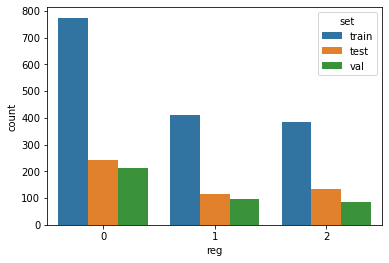

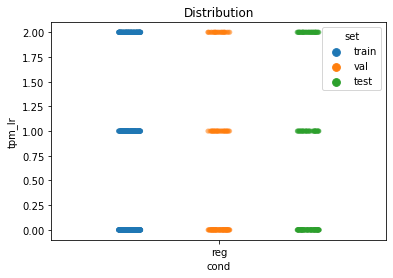

Train Seqs
CACACA: 385
GTGTGT: 412
NO CACACA: 1186
NO GTGTGT: 1159
BOTH: 0
NEITHER: 774

Val Seqs
CACACA: 86
GTGTGT: 96
NO CACACA: 307
NO GTGTGT: 297
BOTH: 0
NEITHER: 211


In [13]:
plot_train_test_stacks(train_df, test_df, val_df=val_df,score_col='reg')
view_train_test_dist(train_df, test_df,["reg"],val_df=val_df,id_col='id')

print_motifs_in_seqs(train_df, "Train Seqs", m1, m2,seq_col='seq')
print()
print_motifs_in_seqs(val_df, "Val Seqs", m1, m2,seq_col='seq')

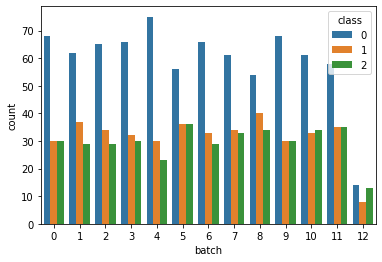

In [14]:
see_batch_class_dist(ohe_train_dl)

## Non-optuna regular ol training

In [15]:
def quick_seq_pred(model, seqs, oracle):
    '''Given some sequences, get the model's predictions '''
    for dna in seqs:
        s = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0).to(DEVICE)
        pred = model(s.float())
        actual = oracle[dna]
        diff = actual - pred.item()
        print(f"{dna}: pred:{pred.item():.3f} actual:{actual:.3f} ({diff:.3f})")

    
def loss_batch(model, loss_func, xb, yb, opt=None,verbose=False):
    '''
    Apply loss function to a batch of inputs. If no optimizer
    is provided, skip the back prop step.
    '''
    if verbose:
        print('loss batch ****')
        print("xb shape:",xb.shape)
        print("yb shape:",yb.shape)
        print("yb shape:",yb.squeeze(1).shape)
        #print("yb",yb)

    xb_out = model(xb.float())
    if verbose:
        print("model out pre loss", xb_out.shape)
        #print('xb_out', xb_out)
        print("xb_out:",xb_out.shape)
        print("yb:",yb.shape)
        print("yb.long:",yb.long().shape)
    
    #loss = loss_func(xb_out, yb.float())
    loss = loss_func(xb_out, yb.long().squeeze(1))
    # ^^ changes for CrossEntropyLoss...

    if opt is not None: # if opt
        loss.backward()
        opt.step()
        opt.zero_grad()

    #print("lb returning:",loss.item(), len(xb))
    return loss.item(), len(xb)

def train_step(model, train_dl, loss_func, opt):
    '''
    Execute 1 set of batch training for an epoch
    '''
    # Set model to Training mode
    model.train()
    tl = [] # train losses
    ns = [] # batch sizes, n
    # collect train loss; provide opt so backpropo happens
    for xb, yb in train_dl:
        # put on GPU
        xb, yb = xb.to(DEVICE),yb.to(DEVICE)

        t, n = loss_batch(model, loss_func, xb, yb, opt=opt)
        tl.append(t)
        ns.append(n)
        
    train_loss = np.sum(np.multiply(tl, ns)) / np.sum(ns)
    return train_loss

def val_step(model, val_dl, loss_func):
    '''
    Execute 1 set of batch validation for an epoch
    '''
    # Set model to Evaluation mode
    model.eval()
    with torch.no_grad():
        vl = [] # val losses
        ns = [] # batch sizes
        for xb, yb in val_dl:
            # put on GPU
            xb, yb = xb.to(DEVICE),yb.to(DEVICE)

            v, n = loss_batch(model, loss_func, xb, yb)
            vl.append(v)
            ns.append(n)

    val_loss = np.sum(np.multiply(vl, ns)) / np.sum(ns)
    return val_loss
    
def fit(epochs, model, loss_func, opt, train_dl, val_dl):
    '''
    Fit the model params to the training data, eval on unseen data.
    Loop for a number of epochs and keep train of train and val losses 
    along the way
    '''
    # keep track of losses
    train_losses = []    
    val_losses = []
    
    # loops through epochs
    for epoch in range(epochs): #tqdm?
        train_loss = train_step(model, train_dl, loss_func, opt)
        train_losses.append(train_loss)
        
        
        val_loss = val_step(model, val_dl, loss_func)
        print(epoch, val_loss)
        val_losses.append(val_loss)

    return train_losses, val_losses

def run_model(train_dl,test_dl, model, loss_func, lr=0.01, epochs=20):
    '''
    Given data and a model type, run dataloaders with MSE loss and SGD opt
    '''
    # define loss func and optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=lr) 
    
    # run the training loop
    train_losses, test_losses = fit(epochs, model, loss_func, optimizer, train_dl, test_dl)
    
    #return model, train_losses, test_losses
    return train_losses, test_losses

In [16]:
class DNA_Linear_Deep(nn.Module):
    def __init__(
        self, 
        seq_len,
        h0_size=24,
        h1_size=24
    ):
        super().__init__()
        self.seq_len = seq_len
        
        self.lin = nn.Sequential(
            nn.Linear(4*seq_len, h1_size),
            nn.ReLU(inplace=True),
            nn.Linear(h0_size, h1_size),
            nn.ReLU(inplace=True),
            nn.Linear(h1_size, 3), # 3 for 3 classes
            #nn.Softmax(dim=1)
        )

    def forward(self, xb):
        # Linear wraps up the weights/bias dot product operations
        # reshape to flatten sequence dimension
        xb = xb.view(xb.shape[0],self.seq_len*4)
        out = self.lin(xb)
        #print("Lin out shape:", out.shape)
        return out
    
class DNA_CNN(nn.Module):
    def __init__(self,
                 seq_len,
                 num_filters=31,
                 kernel_size=3
                ):
        super().__init__()
        self.seq_len = seq_len
        self.lin_nodes = num_filters*(seq_len-kernel_size+1)
        
        self.conv_net = nn.Sequential(
            nn.Conv2d(1, num_filters, kernel_size=(4,kernel_size)),
            # ^^ changed from 4 to 1 channel??
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(self.lin_nodes, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
            nn.ReLU(),
            nn.Linear(10, 3),
            #nn.Softmax(dim=1)
            
        ) 

    def forward(self, xb):
        # reshape view to batch_ssize x 4channel x seq_len
        # permute to put channel in correct order
        #xb = xb.view(-1,self.seq_len,4).permute(0,2,1) 
        #xb = xb.permute(0,2,1) 
        # OHE FIX??
        xb = xb.permute(0,2,1).unsqueeze(1)
        # ^^ Conv2D input fix??
        #print(xb.shape)
        out = self.conv_net(xb)
        #print("CNN out shape:",out.shape)
        return out

class Kmer_Linear(nn.Module):
    def __init__(self,num_kmers,h1_size,h2_size):
        super().__init__()
        
        # some arbitrary arch of a few linear layers
        self.lin = nn.Sequential(
            nn.Linear(num_kmers, h1_size), ## TODO: Can this be combined? Bring num_kmers outside?
            nn.ReLU(inplace=True),
            nn.Linear(h1_size, h2_size),
            nn.ReLU(inplace=True),
            nn.Linear(h2_size, 1),
        )
        
        
    def forward(self, xb):
        out = self.lin(xb)
        #print("Lin out shape:", out.shape)
        return out

In [17]:
def plot_confusion(models,genes,oracle,objs):
    '''Get class predictions and plot confusion matrix'''
    dfs = {}
    for model_name,model,ds in models:
        print(f"Running {model_name}")
        data = []
        for gene in genes:
            dna = loc2seq[gene]
            if ds.name == 'ohe':
                s = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0).to(DEVICE)
            elif ds.name == 'kmer':
                s = torch.tensor(u.count_kmers_in_seq(dna,u.kmers(ds.k))).to(DEVICE)
                # need unsqueeze?
            else:
                raise ValueError(f"Unknown DataSetSpec Type {ds.name}. Currently just [ohe, kmer]")

            actual = oracle[gene]
            preds = [x.topk(1) for x in model(s.float())]
            
            for i in range(len(preds)):
                prob,cls = [x.item() for x in preds[i]]
                data.append((gene,actual[i], cls,prob,objs[i],dna))
                
        df = pd.DataFrame(data, columns=['locus_tag','truth','pred','prob','task','seq'])
        c = confusion_matrix(df['truth'].values, df['pred'].values)
        disp = ConfusionMatrixDisplay(confusion_matrix=c)
        disp.plot()
        plt.title(f"{model_name} confusion matrix")
        
        dfs[model_name] = (c,df)
        
    return dfs

### Deep linear

In [18]:
seq_len = len(train_df['seq'].values[0])

mer8motif_model_lin_d = DNA_Linear_Deep(
    seq_len,
    h0_size=100,
    h1_size=100,
)
mer8motif_model_lin_d.to(DEVICE)


#loss_func = torch.nn.MSELoss() 
#w = torch.tensor([1.0,5.0,5.0]).to(DEVICE)
loss_func = nn.CrossEntropyLoss()#weight=w)

mer8motif_train_losses_lin_d, mer8motif_test_losses_lin_d = run_model(
    ohe_train_dl, 
    ohe_val_dl, 
    mer8motif_model_lin_d,
    loss_func,
    lr=0.01,
    epochs=500
)

0 1.0900989852788794
1 1.074933156409033
2 1.0619678145449885
3 1.050151209188175
4 1.0405083764297058
5 1.0330326487393173
6 1.026450419547297
7 1.0223213546452026
8 1.0193502617852985
9 1.017086706998694
10 1.0157013464216664
11 1.015082178831707
12 1.0146936927436265
13 1.01437136053129
14 1.0138933406834687
15 1.0137678339281155
16 1.0135900094612258
17 1.0132153847138694
18 1.0131937204729813
19 1.0133790793916349
20 1.0132432299412542
21 1.0129455594919414
22 1.0129993341047951
23 1.0119882937302722
24 1.0123273316230483
25 1.0121720128386986
26 1.0127163254881026
27 1.0123763721407826
28 1.0116473445455536
29 1.0113366960569192
30 1.0120727190837908
31 1.0120694085235207
32 1.0126321531130764
33 1.0120221525051516
34 1.011505762432671
35 1.0114350142976407
36 1.0109815024237596
37 1.011261804716581
38 1.0107123603044272
39 1.0106347128938475
40 1.0107475692079266
41 1.0100421307954472
42 1.010100832422271
43 1.0099676944523974
44 1.0100220353852094
45 1.0097381031240216
46 1.010

371 2.8149672773958163
372 2.817060943778235
373 2.8242158386240175
374 2.823402321065655
375 2.8285403894710783
376 2.8331526132637004
377 2.8342051912506725
378 2.833734980066314
379 2.8412044163575305
380 2.8440493148095127
381 2.8433899284925777
382 2.848682225205516
383 2.8503434973515325
384 2.852079401792764
385 2.854298215482678
386 2.8559459365961204
387 2.860314522080749
388 2.865598460190169
389 2.8666687296850384
390 2.8691503437420796
391 2.8701699004525145
392 2.8719211201024724
393 2.8726418515804766
394 2.88190182414067
395 2.879670720670666
396 2.8856263500436876
397 2.8872263789480273
398 2.888339715452898
399 2.894052092355626
400 2.89486020393954
401 2.897081406668549
402 2.8988513412669716
403 2.9016248197045944
404 2.90642035644473
405 2.9069011581459723
406 2.9079242335021043
407 2.913846663239651
408 2.911788957416253
409 2.9148276507399467
410 2.917819637681995
411 2.923269981039693
412 2.9252720770945078
413 2.9293895374424284
414 2.9287917419850977
415 2.9302

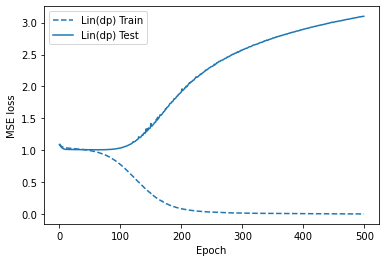

DNA_Linear_Deep(
  (lin): Sequential(
    (0): Linear(in_features=1200, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=100, out_features=3, bias=True)
  )
)

In [19]:
# to plot loss
mer8motif_lin_d_data_label = [((mer8motif_train_losses_lin_d,mer8motif_test_losses_lin_d),"Lin(dp)")]
tu.quick_loss_plot(mer8motif_lin_d_data_label)

mer8motif_model_lin_d

### CNN model

In [20]:
class TINKER_DNA_CNN(nn.Module):
    def __init__(self,
                 seq_len,
                 num_filters0=32,
                 num_filters1=32,
                 kernel_size0=8,
                 kernel_size1=8,
                 conv_pool_size0=1,
                 conv_pool_size1=1,
                 fc_node_num0 = 10,
                 fc_node_num1 = 10
                ):
        super().__init__()
        
        self.seq_len = seq_len
        
        # calculation for number of linear nodes need to come after final conv layer
        linear_node_num = int(np.floor((seq_len - kernel_size0 + 1)/conv_pool_size0))
        linear_node_num = int(np.floor((linear_node_num - kernel_size1 + 1)/conv_pool_size1))
        linear_node_num = linear_node_num*num_filters1
        #linear_node_num = linear_node_num*num_filters0
        
        self.conv_net = nn.Sequential(
            # Conv layer 0
            nn.Conv2d(1, num_filters0, kernel_size=(4,kernel_size0)),
            # ^^ changed from 4 to 1 channel??
            nn.ReLU(),
            nn.MaxPool2d((1,conv_pool_size0)), # def stride = kernel_size
            nn.Dropout(0.5),

            # Conv layer 1
            nn.Conv2d(num_filters0, num_filters1, kernel_size=(1,kernel_size1)),
            nn.ReLU(),
            
            nn.Flatten(),
            # Fully connected layer 0
            nn.Linear(linear_node_num, fc_node_num0),
            nn.ReLU(),
            nn.Dropout(0.5),
            # Fully connected layer 0
#             nn.Linear(fc_node_num0, fc_node_num1),
#             nn.ReLU(),
            # final prediction
            nn.Linear(fc_node_num0, 3),
            #nn.Softmax(dim=1)
        ) 

    def forward(self, xb):
        # reshape view to batch_ssize x 4channel x seq_len
        # permute to put channel in correct order
        
        #xb = xb.permute(0,2,1) 
        # OHE FIX??
        
        xb = xb.permute(0,2,1).unsqueeze(1)
        # ^^ Conv2D input fix??
        
        out = self.conv_net(xb)
        return out

In [21]:
w

NameError: name 'w' is not defined

In [22]:
# make model
seq_len = len(train_df['seq'].values[0])
mer8motif_model_cnn = TINKER_DNA_CNN(
    seq_len,
    num_filters0=32,
    num_filters1=32,
    kernel_size0=6,
    kernel_size1=6,
    conv_pool_size0=3,
#     conv_pool_size1=1,
    fc_node_num0=10,
    fc_node_num1=10
)
mer8motif_model_cnn.to(DEVICE)

# make loss func
#loss_func = torch.nn.MSELoss() 
#w = torch.tensor([1.0,5.0,5.0]).to(DEVICE)
loss_func = nn.CrossEntropyLoss()#weight=w)

# run model
mer8motif_train_losses_cnn, \
mer8motif_test_losses_cnn = run_model(
    ohe_train_dl, 
    ohe_val_dl, 
    mer8motif_model_cnn, 
    loss_func,
    lr=0.01,
    epochs=5000,
)

0 1.055871523366933
1 1.0469375193574046
2 1.0395752097510806
3 1.0362663957605531
4 1.0349329000210945
5 1.0325247422429442
6 1.0300635709107377
7 1.026263851245851
8 1.0253886648716817
9 1.0239808037687501
10 1.0217243669597247
11 1.0235252019406578
12 1.0231952815868777
13 1.0239911968168107
14 1.0241713244799742
15 1.0260116759754017
16 1.02359964071036
17 1.0227626374052985
18 1.022873577877462
19 1.0240852229164454
20 1.0258713184118877
21 1.0226800957405537
22 1.0191232976112656
23 1.0204463684528535
24 1.0223760817190466
25 1.0252537460424214
26 1.0237351437561384
27 1.018531874239293
28 1.023609557224594
29 1.0207958003036848
30 1.0196778182765
31 1.021751661337059
32 1.0194532631614432
33 1.0173037586018026
34 1.0200948284479194
35 1.0213884834114833
36 1.0190066032433935
37 1.0177217324574788
38 1.0221540306057335
39 1.0204258332119036
40 1.023231105040048
41 1.0199760923555485
42 1.0215797821680705
43 1.0198784693506837
44 1.018713033532975
45 1.018675665212345
46 1.0180700

369 1.0068333320338612
370 1.010798288665655
371 1.0085426602351453
372 1.0583001572363855
373 1.0109886602894345
374 1.016502247815217
375 1.0180145778122143
376 1.0208542668485763
377 1.0272650654989344
378 1.0121691349808497
379 1.0356982473198695
380 1.0367852837681466
381 1.0127404327610976
382 1.0502619919279452
383 1.0539502321005474
384 1.0465556310333368
385 1.0311993997515614
386 1.0397855543908272
387 1.126927838070702
388 1.016692223288024
389 1.0197126152557878
390 1.068367624100838
391 1.0226450011930392
392 1.0152220277082527
393 1.014202483586076
394 1.024276337247465
395 1.1326941931217378
396 1.0443461551011064
397 1.0307897420329901
398 1.013723638069842
399 1.0241516340173231
400 1.0202584253012679
401 1.1196671081256624
402 1.0185318950175026
403 1.0187529035803622
404 1.0181698800649959
405 1.0229912773343444
406 1.0243922738931865
407 1.0295616151722333
408 1.0367261456472576
409 1.0279047947196864
410 1.0329278112974483
411 1.0146223499271403
412 1.0434270812051

734 1.1596097970433514
735 1.05925767658321
736 1.1119141072110668
737 1.1664834243953985
738 1.1234413703889337
739 1.1644515105482882
740 1.213349689054125
741 1.0647003304867344
742 1.1948521658967772
743 1.1145435856802166
744 1.054521491206026
745 1.124475566485456
746 1.0605622308551508
747 1.1962195337577024
748 1.1933848645547571
749 1.2036458299360202
750 1.1532322796246477
751 1.1408083399440192
752 1.075557312589262
753 1.0767109776271209
754 1.064320912494611
755 1.1134364805148758
756 1.1036100860770421
757 1.088840412729569
758 1.0758076172141933
759 1.0832014056562467
760 1.0892070234580198
761 1.078320795646454
762 1.1649047858235793
763 1.081056331253537
764 1.0711699891029727
765 1.1546459780394576
766 1.268786053014469
767 1.1131868043928657
768 1.1479856036698242
769 1.093777819444205
770 1.1079379593143026
771 1.1123666344708159
772 1.0600814425004954
773 1.1751671441032079
774 1.1476061004415419
775 1.1097575599000653
776 1.1265345435712781
777 1.222449766770574
7

1092 1.0384589022655826
1093 1.051230641115106
1094 1.0654499718857782
1095 1.0465882646521842
1096 1.0585232869966037
1097 1.0966626129684254
1098 1.0995916167591668
1099 1.027961788741687
1100 1.0293329119985644
1101 1.089905787060279
1102 1.0100213054178933
1103 1.1983523174703272
1104 1.0637052935801692
1105 1.0360822242331567
1106 0.9872950600607098
1107 1.0165374818952333
1108 1.1107497457936217
1109 0.9910467068354288
1110 1.132283851693908
1111 1.0816840433892403
1112 1.1080848473022307
1113 1.040161151315723
1114 1.0833753826660661
1115 1.0929776997359957
1116 1.0670759756753159
1117 1.1564586393099099
1118 1.0696847827076608
1119 0.9778130975085058
1120 1.1446002852219055
1121 1.169739706219001
1122 1.0530479533678399
1123 1.1634944549953665
1124 1.0495370153252406
1125 1.0277904369145556
1126 1.0659229069872365
1127 0.9984080289459714
1128 1.0141155801656592
1129 1.0070741796918194
1130 1.1112413312339298
1131 1.1480730135022228
1132 1.0026480497901373
1133 1.037701607357151

1437 0.9454357813636158
1438 0.9903777532905113
1439 0.9418572681854093
1440 0.9327100738314272
1441 1.0362181184249373
1442 0.9593507366932682
1443 0.9309254126391034
1444 0.9482682744661967
1445 1.0165984242320365
1446 0.9923707968709427
1447 1.015394629412935
1448 0.9116515765966653
1449 0.9451776627669201
1450 0.9972852095392825
1451 0.9515138279087367
1452 0.9813205633151318
1453 0.9827077584412262
1454 0.9179109618560655
1455 0.9132387835257533
1456 0.9477442066178067
1457 0.9574006092154039
1458 1.0054731168819748
1459 0.908365474705781
1460 0.9188122044082816
1461 0.934920407585212
1462 1.0359249846019212
1463 0.9115789902725899
1464 0.9037211221896359
1465 0.9283163511116086
1466 0.9339098610344128
1467 0.9357687991690696
1468 0.9265790358754514
1469 0.9839462835066798
1470 0.9558853728473945
1471 1.0418038477424447
1472 1.0235714381584382
1473 1.0180482934146133
1474 0.9299999622594916
1475 0.9553416744443296
1476 0.9754891401635478
1477 0.9520088651101402
1478 0.935219888013

1781 0.9360738953257942
1782 0.9495584095707377
1783 0.908592933006869
1784 0.8820129006570229
1785 0.8709575632449628
1786 0.9086697297241851
1787 0.985447627897481
1788 0.8529651670055535
1789 0.958680598183746
1790 0.871587897378373
1791 0.8655825926147345
1792 0.9271185044720579
1793 0.8654063968864713
1794 0.8439698148016408
1795 0.9505482385783401
1796 0.8404613294977572
1797 0.9250922777877206
1798 0.8775435217464244
1799 0.8800264310290795
1800 1.0145009856187661
1801 0.8590629191799019
1802 0.8283201493986387
1803 0.9124153188166727
1804 0.9480552289625463
1805 0.910020269662066
1806 0.8517202827463319
1807 0.9698733646451062
1808 0.9280664242860925
1809 0.8993912228494504
1810 0.8657411552264187
1811 0.9325280080314811
1812 0.942186667112297
1813 0.9426349058709376
1814 0.8755014914896045
1815 0.8623805121914424
1816 0.9142051816896628
1817 0.8762501969592262
1818 0.8649200759164553
1819 0.8643118511629468
1820 0.9122765604169617
1821 0.960134560521929
1822 0.9477771602514136

2126 0.8095374080061003
2127 0.8658840251332931
2128 0.8802256296002531
2129 0.9514647015481809
2130 0.9001637067806934
2131 0.9281346796426457
2132 1.080038618495446
2133 0.8977637213605051
2134 0.8642993501124491
2135 0.8582389583721113
2136 0.9428745781192343
2137 0.8745460531487113
2138 0.8326878503685385
2139 0.8547377600014665
2140 0.881238703812655
2141 0.9076351191251333
2142 0.8717201731283852
2143 0.8194084754426971
2144 0.9656658262090222
2145 0.9000248329633368
2146 0.8994669154400133
2147 0.8682125870508092
2148 0.8520452938310366
2149 0.8390031808811896
2150 0.829393738098727
2151 0.8115190479894934
2152 0.8447916817119103
2153 0.8793510694540184
2154 0.9837137572941282
2155 0.9018333863666039
2156 0.8117565389807898
2157 0.9063386330167755
2158 0.8928476523503699
2159 0.8725534889837561
2160 0.9326823455383456
2161 0.8717393529324131
2162 0.8985240911406112
2163 0.8425908977445452
2164 0.8551297648869095
2165 0.9147426522415103
2166 0.841772130882467
2167 0.8348244405884

2474 0.8960889185051275
2475 0.9757960646510427
2476 0.8509908323069565
2477 0.868554130765318
2478 0.8572128339274846
2479 0.91054761106428
2480 0.8397181718100725
2481 0.9195308814218632
2482 0.8388135604579333
2483 0.824170325093597
2484 0.8204673877502519
2485 0.8450177207247902
2486 0.8922414447515066
2487 0.8338476381532411
2488 0.7864505216365553
2489 0.8617884145134884
2490 0.853872681543724
2491 0.8187486142602586
2492 0.8187147489637515
2493 0.9062801510019763
2494 0.9322221253361107
2495 0.882351551650438
2496 0.8294617265235377
2497 0.8599538596835149
2498 0.8727247273648968
2499 0.8613221753037916
2500 0.8486245015195308
2501 0.7969929856501766
2502 0.8489472351911413
2503 0.8356663951740313
2504 0.8512155495527136
2505 0.8570380794789652
2506 0.8115641172908948
2507 0.831712262017733
2508 1.031243939436119
2509 1.043905572733503
2510 0.8815733816180824
2511 0.8502190492232033
2512 0.8240656602473659
2513 0.8653150646741153
2514 0.855996409141987
2515 0.9338178648293474
25

2819 0.7682393768058176
2820 0.8134465341956257
2821 0.8160511092981916
2822 0.7914603578528678
2823 0.836976381506932
2824 0.8190372974514658
2825 0.838475260570759
2826 0.7800789266142226
2827 0.832014405242056
2828 0.8661227370339799
2829 0.8716946502071604
2830 0.946450776119572
2831 0.8261227759392814
2832 0.7922046815469368
2833 0.7814463599947573
2834 0.9544035799934057
2835 0.7875361254500373
2836 0.8432260340710026
2837 0.8140308523299433
2838 0.8366865394376313
2839 0.8568003036593663
2840 0.7846959083134891
2841 0.8283432024429166
2842 0.7988512946752495
2843 0.8129611218551946
2844 0.7764921194421123
2845 0.7539257495154558
2846 0.8593925706302846
2847 0.7763387315145885
2848 0.7856869612637973
2849 0.8065430446132146
2850 0.8216052169108209
2851 0.817892789385701
2852 0.8466783341863986
2853 0.8415524336217924
2854 0.8207119632009938
2855 0.8023134659568165
2856 0.7992650184012552
2857 0.9217283156991914
2858 0.8060219472904545
2859 0.8195772952099186
2860 0.78115016237166

3163 0.7740737183100092
3164 0.7968568692680533
3165 0.798415100908158
3166 0.8164577652479856
3167 0.8211611307607656
3168 0.8005690630762329
3169 0.7863256086526633
3170 0.8076143355769966
3171 0.7960142168683253
3172 0.8403213943233927
3173 0.8134033831627921
3174 0.7628341942039761
3175 0.7735629677772522
3176 0.7938323004251825
3177 0.8030616085947925
3178 0.9621565786330147
3179 0.8004925079624768
3180 0.7691107797258683
3181 0.8392720575854372
3182 0.8522003511436113
3183 0.8677635467386124
3184 0.8051355517547549
3185 0.8355081648620334
3186 0.7825032924574447
3187 0.8219778475567281
3188 0.8174299018376959
3189 0.8566238704225186
3190 0.795083622441037
3191 0.7762804636518463
3192 0.8301057224055283
3193 0.7472860414259913
3194 0.807327314945881
3195 0.8548608707410992
3196 0.7911304230908401
3197 0.8721171347542876
3198 0.7601095039122584
3199 0.8524712386325419
3200 0.7573163930999717
3201 0.7821008537258507
3202 0.8169771297894058
3203 0.7967111985495375
3204 0.810794874153

3508 0.7711352722638739
3509 0.768855094909668
3510 0.741862184825441
3511 0.8324258059035731
3512 0.8301821906148023
3513 0.7996812101842187
3514 0.7710787015410173
3515 0.8254822943046802
3516 0.7944839957712867
3517 0.7663735691221009
3518 0.7609072970676665
3519 0.7917138106040372
3520 0.7279462470049773
3521 0.7477674253720971
3522 0.7622949822258404
3523 0.7543499070876124
3524 0.7623589345213718
3525 0.8001920612713763
3526 0.7207010309508132
3527 0.7505965266215588
3528 0.7401032951345274
3529 0.8046726717900381
3530 0.8122449541516583
3531 0.7617697344178158
3532 0.778426581515004
3533 0.7688378975288255
3534 0.7687156619006441
3535 0.7457270645003282
3536 0.7396270270262663
3537 0.7591249493848883
3538 0.7159721784615941
3539 0.799151394810082
3540 0.7840449512763181
3541 0.8116835125226708
3542 0.7882228831905141
3543 0.7605378506444489
3544 0.7318158395417774
3545 0.7582091956041545
3546 0.7799496500546695
3547 0.770292724058525
3548 0.7846400037066628
3549 0.75950902685257

3851 0.7478947854830715
3852 0.72665286670811
3853 0.741584730663979
3854 0.7417626746434899
3855 0.7388804468489786
3856 0.7226356239112582
3857 0.7337796093550044
3858 0.7913549777508996
3859 0.7372971850497122
3860 0.7315758660852757
3861 0.7332392680735988
3862 0.7048439906753656
3863 0.7305014077337036
3864 0.7280100153299385
3865 0.7434003254536151
3866 0.7132528039031963
3867 0.7069894189142999
3868 0.722423825100178
3869 0.7514041974647658
3870 0.712165106343859
3871 0.764877016611075
3872 0.7212823050016058
3873 0.7375336635203762
3874 0.7015003373908026
3875 0.7499660465856848
3876 0.7446173009374972
3877 0.7030025641730117
3878 0.7111322640159354
3879 0.791314016468349
3880 0.7176912323815828
3881 0.7458899285047109
3882 0.7328086929163556
3883 0.752184256494197
3884 0.6851217344820347
3885 0.7256347763022697
3886 0.7316874235337624
3887 0.7714203526348862
3888 0.7424021577107087
3889 0.7309329945015847
3890 0.7248793623526284
3891 0.7335387855085708
3892 0.7402707209417232


4196 0.6869865954680601
4197 0.6613633541660454
4198 0.7277540705586207
4199 0.6472755769130231
4200 0.7029166928381106
4201 0.7550959028967161
4202 0.677596111485673
4203 0.6748224888139098
4204 0.7729136426636888
4205 0.6798326626382105
4206 0.6816341676784836
4207 0.6933419006774747
4208 0.6751056889844608
4209 0.6964165362086309
4210 0.7214655111764223
4211 0.7556786280855271
4212 0.7216899188723577
4213 0.6684423815506408
4214 0.6611330547102232
4215 0.7171100004938723
4216 0.7005127716913782
4217 0.6921365872290904
4218 0.7076947484307616
4219 0.692258182827753
4220 0.745159661193537
4221 0.6947616206780645
4222 0.6995122532808143
4223 0.6850367585817972
4224 0.7052821627706668
4225 0.6838725071220301
4226 0.7387943325455255
4227 0.7455318476104251
4228 0.7489925339325088
4229 0.6695500172428199
4230 0.748548167959121
4231 0.6606067604084355
4232 0.6506527766926598
4233 0.6770369023767137
4234 0.7108766661042172
4235 0.7121738830898857
4236 0.7121926354997941
4237 0.6823049269559

4540 0.6737112186033913
4541 0.7493665568701183
4542 0.7199679567613675
4543 0.6573326281312161
4544 0.6653319956692121
4545 0.6020492518524481
4546 0.6418726691459579
4547 0.7071638513764049
4548 0.6902311961462783
4549 0.6826390373797817
4550 0.634637321527981
4551 0.6638988763018115
4552 0.6809224186052802
4553 0.6568125457557407
4554 0.6767681708166011
4555 0.627473699985873
4556 0.7139953825309986
4557 0.674441699611625
4558 0.670422067624012
4559 0.6497280103256381
4560 0.6469312572600581
4561 0.6766648394157565
4562 0.6931823592149574
4563 0.6907817372535628
4564 0.6419050597962532
4565 0.6578022165759526
4566 0.6391396222223762
4567 0.7535704219614277
4568 0.6691749993778063
4569 0.6718713553200545
4570 0.7045429696260215
4571 0.6809545703819994
4572 0.7064836941299244
4573 0.6967098488455814
4574 0.6788290458477787
4575 0.6623562049623057
4576 0.6802925381041666
4577 0.6604695077464174
4578 0.6730105869339319
4579 0.6818236337059933
4580 0.7281165668982585
4581 0.6698686680720

4885 0.623938935100274
4886 0.5900097995920642
4887 0.638415959803506
4888 0.6219053188049762
4889 0.6385947361247231
4890 0.6052120405299063
4891 0.6362876394626141
4892 0.6087641700836842
4893 0.6297487677205307
4894 0.6383436787826111
4895 0.6088542349769263
4896 0.630226087479191
4897 0.6327729260041817
4898 0.6308074769476291
4899 0.6731809087988682
4900 0.6696899998885681
4901 0.6339662379890908
4902 0.6505945986160492
4903 0.6090141992835901
4904 0.6590899251799547
4905 0.62801962969564
4906 0.6171339066277327
4907 0.6692576610101695
4908 0.6492345798713257
4909 0.6384021670157066
4910 0.6260727367934986
4911 0.6280075217627994
4912 0.6404935925364797
4913 0.6021707752582074
4914 0.6150513389941693
4915 0.6581591439004466
4916 0.6078679423599146
4917 0.643078036284022
4918 0.6156274225875622
4919 0.5953065223669581
4920 0.6695143927751304
4921 0.6843693552126411
4922 0.6281957550509892
4923 0.6610134711095699
4924 0.6546540392264155
4925 0.6397465682818386
4926 0.667215875693556

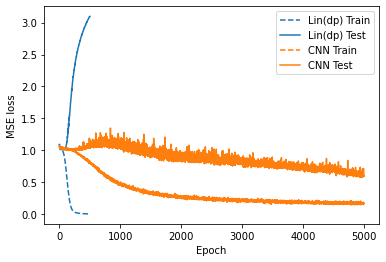

TINKER_DNA_CNN(
  (conv_net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 6), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
    (4): Conv2d(32, 32, kernel_size=(1, 6), stride=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=2976, out_features=10, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.5, inplace=False)
    (10): Linear(in_features=10, out_features=3, bias=True)
  )
)

In [23]:
# to plot loss
mer8motif_cnn_data_label = [((mer8motif_train_losses_cnn,mer8motif_test_losses_cnn),'CNN')]

tu.quick_loss_plot(mer8motif_lin_d_data_label+mer8motif_cnn_data_label)

mer8motif_model_cnn

Running LinearDeep
Running CNN
Running LinearDeep
Running CNN


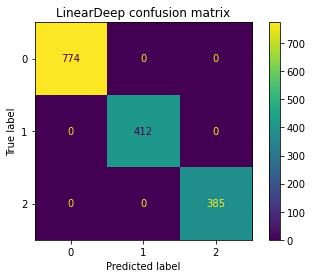

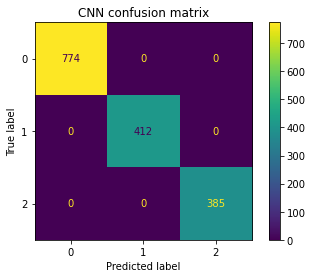

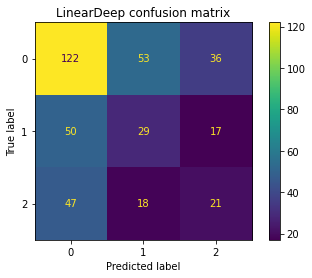

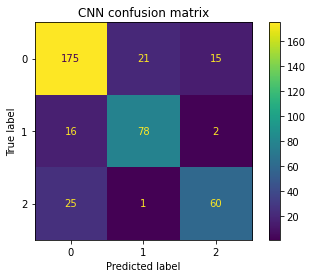

In [24]:
models = [
    ("LinearDeep",mer8motif_model_lin_d,DatasetSpec('ohe')),
    ("CNN",mer8motif_model_cnn,DatasetSpec('ohe')),
#     ("Kmer1_8mer",mer8motif_model_kmer1,DatasetSpec('kmer',k=1)),
#     ("Kmer3_8mer",mer8motif_model_kmer3,DatasetSpec('kmer',k=3)),
]


train_seqs =  train_df['id'].values #val_df['locus_tag'].values #
val_seqs =  val_df['id'].values #val_df['locus_tag'].values #
task = "6mer_motif_reg"

oracle_syn = dict([(a,[b]) for a,b in syn_df[['id','reg']].values])


dfs_train = plot_confusion(models, train_seqs, oracle_syn,[task])
dfs_val = plot_confusion(models, val_seqs, oracle_syn,[task])

In [25]:
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score,precision_recall_curve

def cls_report(df,model_name):
    '''Basic print out of precicion/recall/f1 scores'''
    
    acc = accuracy_score(df['truth'].values,df['pred'].values)
    print(f"{model_name} (acc={acc:.3f})")
    for a in ['micro','macro']:#,'weighted']:
        p = precision_score(df['truth'].values,df['pred'].values,labels=[0,1,2],average=a)
        r = recall_score(df['truth'].values,df['pred'].values,labels=[0,1,2],average=a)
        f1 = f1_score(df['truth'].values,df['pred'].values,labels=[0,1,2],average=a)
        print(f"{a}: p={p:.3f}\t r={r:.3f}\t f1={f1:.3f}")

def quick_classify(model, seqs,oracle):
    '''Given some sequences, get the model's predictions '''
    mis_classified = []
    for gene in seqs:
        dna = loc2seq[gene]
        s = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0).to(DEVICE)
        pred = model(s.float())
        prob,cls = pred.topk(1)
        actual = oracle[gene][0]
        correct = (cls.item() == actual)
        if not correct:
            #print(f"{gene}: pred:{cls.item()} actual:{actual}")
            mis_classified.append(gene)
            print(f"{gene}: pred:{cls.item()} actual:{actual} ({pred.tolist()[0]})")

    print('done')
    return mis_classified
        

In [26]:
lind_res = dfs_val['LinearDeep'][1]
cnn_res = dfs_val['CNN'][1]

cls_report(lind_res,"LinearDeep")
print()
cls_report(cnn_res,"CNN")

LinearDeep (acc=0.438)
micro: p=0.438	 r=0.438	 f1=0.438
macro: p=0.377	 r=0.375	 f1=0.375

CNN (acc=0.796)
micro: p=0.796	 r=0.796	 f1=0.796
macro: p=0.790	 r=0.780	 f1=0.784


In [27]:
mis = quick_classify(mer8motif_model_cnn,val_seqs,oracle_syn)

117: pred:0 actual:1 ([4.613938808441162, 0.925975501537323, -4.498648643493652])
124: pred:1 actual:0 ([1.7413114309310913, 2.287083625793457, -3.4097321033477783])
156: pred:0 actual:2 ([3.6934096813201904, -4.586333751678467, 1.9457027912139893])
160: pred:0 actual:2 ([4.4811859130859375, -3.4337193965911865, -0.08458006381988525])
168: pred:0 actual:2 ([5.341299057006836, -6.227898597717285, 1.9137192964553833])
178: pred:0 actual:1 ([1.9625372886657715, 1.861664056777954, -2.85068416595459])
215: pred:1 actual:0 ([1.2100088596343994, 1.300119161605835, -1.9087547063827515])
216: pred:0 actual:2 ([2.7568764686584473, -2.501988649368286, 0.8731989860534668])
235: pred:1 actual:0 ([0.23507115244865417, 3.719688653945923, -3.339627981185913])
267: pred:2 actual:0 ([3.2046990394592285, -6.856052398681641, 4.73853874206543])
320: pred:1 actual:0 ([-0.2840021550655365, 1.2003448009490967, -0.6229467391967773])
392: pred:2 actual:0 ([0.6311466693878174, -2.250880241394043, 2.2764070034027

In [87]:
for x in mis:
    print(f"{x}:{loc2seq[x]}")

39:AGAAGGTGTGTTCCAGTTGCACACGGTTCTGACATCCCTTAACATGTTCTGCTTCCAATACTAATCGATGATCTCAATTGCATACTGTCCTTCTATCATAAGTGCTAGTCGTCCTCAGCCACGGTGATGTCTGTGCCAACTTGCTCAACGTACCATGGTTTTGAGTGCTCGTCTCTTACTGCTTGTTCGAACATGCTCCAATGTCGCCGTTGCATGCCTGTGGTATACACGACTGCGTCAACACCAGAAACCTAACTCAAACCACGCGATTTGTACCCTGCGGTCAACCGGTGGTAAAAC
41:ATGGACCTATTCTGCGCCCGTAGACACGGAAGTTGCCCCATCCGTATACTCGTAGTGCAGCGCCAGGATGCCCCGAAATCTAGACGAGTGCATGTTTCATGTCGATGCTCCGTGCGCAATCATCCGCGCAGTATAAGGAATGGTCGATACTCAGTCATGTGCGATATGTCCATAATCAGCCAGGGAGAGATTTCGGGCGCGCGCCTTGTTCACATCGTCAGTTATACCATACTACTCACTTTTATAGAGTAGGCCGCGTTGTTAGACTTGGTGACTACAGTGTGTCTCCTATAGTTCGAT
44:ACGGTGCTCGATAACACCCGGATCGCGCCAGCTGTGCCCGGACACGAGGTAATTGAGTCGTCACCAAAAACCGAATGAGAAAGGACCAAGCCCTGCTGAATTACTTATGGTGAACTCAGGAGTGTGTATACACAGTTCGACGTAGCTAGTCCGATTACTTGGGCCGAAACCAGATAAGATAGTTAATTCGCGCTCTGTCCGATACAGATCGCTTACTGAACTATACTTCTCCTTGTTTAGTCCATGGCGTGACCCTAAAGTTAGTACGTCCCGGCGTCAATACTTGATAAAGATCCACCT
45:TAAAGCAAGGCAGACATGAAATATGGTTCGTCTTGAAGGTGTAGGCCGCACCCATACGCACGGTCCGATTGTCACCTCAGGCCCC

## Rebalance sampler

In [28]:
from torch.utils.data.sampler import WeightedRandomSampler


In [29]:
# retry making dataloader with weighted sampler
class_sample_count = train_df['reg'].value_counts().values
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in train_df['reg'].values])
samples_weight = torch.from_numpy(samples_weight).double()


sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
sampler

In [30]:
print(samples_weight.unique())

tensor([0.0013, 0.0024, 0.0026], dtype=torch.float64)


In [31]:
# Dfs from further spliting train into train and val
dls = tu.build_dataloaders_single(
    train_df, 
    val_df, 
    dataset_types,
    seq_col='seq',
    target_col='reg',
    sampler=sampler,
    shuffle=False
)

kmer6_train_dl,kmer6_val_dl = dls['kmer_6']
kmer3_train_dl,kmer3_val_dl = dls['kmer_3']
ohe_train_dl,ohe_val_dl = dls['ohe']

In [32]:
print(full_train_df.shape)
print(test_df.shape)
print(train_df.shape)
print(val_df.shape)

(1964, 4)
(492, 5)
(1571, 6)
(393, 6)


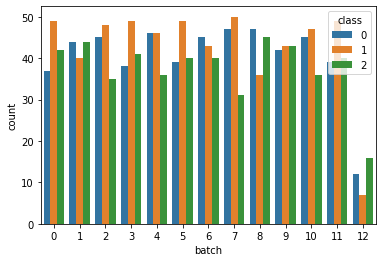

In [33]:
see_batch_class_dist(ohe_train_dl)
# the exact dist changes everytime

In [34]:
# make model
seq_len = len(train_df['seq'].values[0])

mer8motif_model_cnn = TINKER_DNA_CNN(
    seq_len,
    num_filters0=32,
    num_filters1=32,
    kernel_size0=6,
    kernel_size1=6,
    conv_pool_size0=3,
#     conv_pool_size1=1,
    fc_node_num0=10,
    fc_node_num1=10
)
mer8motif_model_cnn.to(DEVICE)

# make loss func
#loss_func = torch.nn.MSELoss() 
#w = torch.tensor([1.0,5.0,5.0]).to(DEVICE)
loss_func = nn.CrossEntropyLoss()#weight=w)

# run model
mer8motif_train_losses_cnn, \
mer8motif_test_losses_cnn = run_model(
    ohe_train_dl, 
    ohe_val_dl, 
    mer8motif_model_cnn, 
    loss_func,
    lr=0.01,
    epochs=5000,
)

0 1.1137117456843835
1 1.111646946756591
2 1.1105256890522615
3 1.1107842524846394
4 1.1107585418012003
5 1.1108355070191789
6 1.109548977919814
7 1.1086330741416408
8 1.1066310011400218
9 1.105839883401497
10 1.104419757694992
11 1.10308658743026
12 1.105176323849433
13 1.1073895061895744
14 1.106647074677562
15 1.1061490944020318
16 1.1067184130957413
17 1.1067426110648624
18 1.1055896743259963
19 1.107294290727028
20 1.107648282257352
21 1.1064579593012958
22 1.1041831175486247
23 1.1065479350150693
24 1.1067636501394762
25 1.1068860380400836
26 1.1065660891035434
27 1.1064923619496003
28 1.1052118382077787
29 1.1056766786041454
30 1.1051237316228657
31 1.106354780172877
32 1.1059516498454047
33 1.1063899262867507
34 1.107281692155445
35 1.1075822278743481
36 1.1073055707164696
37 1.1071666130279463
38 1.1066520526512282
39 1.1050986315457876
40 1.1055960979777135
41 1.10651567085402
42 1.1051300745883972
43 1.1047074506604337
44 1.1053600162646848
45 1.1057230965175096
46 1.1030022

365 1.0556899187825715
366 1.0597100288206687
367 1.079799679096115
368 1.0427698345888055
369 1.0464440484083335
370 1.1174594215461013
371 1.07986708573106
372 1.0735010754971104
373 1.06163505925477
374 1.100251410450341
375 1.0412077946213971
376 1.0833867242318074
377 1.1055633114797772
378 1.1134613876731039
379 1.0487587157703235
380 1.052043339375018
381 1.096673841088176
382 1.1651339260979767
383 1.0699517105068566
384 1.0482174279428924
385 1.117828690065379
386 1.1062125598504646
387 1.1082277464805972
388 1.0409364569884827
389 1.061569675234438
390 1.1247442135677386
391 1.0669802054194093
392 1.0477818720819994
393 1.1156610465838406
394 1.0601285935661569
395 1.0681573019076243
396 1.0774892692954183
397 1.098969437997153
398 1.0854107387193286
399 1.0445983810279205
400 1.0912120041956428
401 1.0502578114128598
402 1.0395931375542367
403 1.1768167634653377
404 1.0505218281394046
405 1.13677734151748
406 1.0787902166521883
407 1.0652200129195935
408 1.074532056582793
40

728 1.000463673328322
729 0.9581050260073053
730 1.0151087938980898
731 0.9716903577930751
732 0.9939715813741126
733 0.9492281623772386
734 1.0418857551409695
735 1.0409446724195213
736 0.9629810881675351
737 1.0922158537930204
738 1.0294470873497825
739 0.9646783445324303
740 1.0258709450107797
741 0.9532684084719981
742 0.9561615363332151
743 0.952883777424276
744 0.9958446074381433
745 1.0243827282017424
746 1.0361754072228158
747 0.9642011365514371
748 0.9660089684806707
749 0.936453722967143
750 1.0151785141942458
751 0.9649023953588257
752 0.9780142654596091
753 0.9583581306855491
754 0.9452409386331495
755 0.954009867199808
756 1.0164769983473625
757 1.021893565436356
758 0.9623491073989383
759 0.9545353177849573
760 1.070411825604718
761 1.0074418919687054
762 0.9269705112957166
763 0.9296994606653849
764 0.9641406379886559
765 0.9464731483362406
766 0.9886257933599651
767 0.9704842973908092
768 0.950583708801949
769 0.963172126362342
770 0.9495429105431069
771 0.9230035358409

1083 0.807073987318966
1084 0.8367631505160538
1085 0.7939658932406787
1086 0.7986420898037102
1087 0.7828752538023408
1088 0.8082413714350635
1089 0.8408849348548715
1090 0.7913428607181132
1091 0.7842377888337346
1092 0.7855645530399779
1093 0.7872322323061431
1094 0.8204492075752666
1095 0.7679930908686029
1096 0.7747946323935919
1097 0.8172957566554916
1098 0.8032176224633331
1099 0.7895891852961242
1100 0.791179902377626
1101 0.7748208261324856
1102 0.7883009343353543
1103 0.7887771158424649
1104 0.7908127984321148
1105 0.8084363855478418
1106 0.7696760635036245
1107 0.7840783872070507
1108 0.7721147390115656
1109 0.7965242381920948
1110 0.8640330007664727
1111 0.8018924440743056
1112 0.8093757436779012
1113 0.8012711483103628
1114 0.7799820241733968
1115 0.8036383851490555
1116 0.78299275184709
1117 0.8368065231325669
1118 0.7648832508322544
1119 0.7717968533360624
1120 0.7532226478173836
1121 0.7695747296925416
1122 0.7767447844413097
1123 0.767794327274837
1124 0.76004700169308

1431 0.6859144768642105
1432 0.6779469862845714
1433 0.6466404364915901
1434 0.6990644771027504
1435 0.6533651741709722
1436 0.6689681363773103
1437 0.6734630923538111
1438 0.6672514338833079
1439 0.666625889658018
1440 0.7159200436589676
1441 0.6853395348590142
1442 0.6946975279400367
1443 0.6947359840075175
1444 0.6415561110008764
1445 0.6548465067193708
1446 0.6405563371175421
1447 0.6755357041917078
1448 0.6392883899557682
1449 0.6456291457168929
1450 0.6612248414648701
1451 0.6568541393328562
1452 0.6358019868836148
1453 0.6569635250792856
1454 0.6910588205922348
1455 0.6978933612505595
1456 0.6780103947066776
1457 0.6566252773651337
1458 0.6734932611006816
1459 0.6845678561213059
1460 0.6663767288962696
1461 0.6598682664429565
1462 0.6804417309566915
1463 0.7102131981582739
1464 0.786744726674854
1465 0.6596721874848577
1466 0.6773229491619663
1467 0.6400463785833985
1468 0.6490509029259816
1469 0.7651394044473274
1470 0.7137072418482249
1471 0.6851977287358
1472 0.65902719773712

1776 0.5713335013268255
1777 0.5424050640210547
1778 0.5634263031203631
1779 0.5460926644674694
1780 0.5382271808674014
1781 0.5763300935579013
1782 0.5435028259687448
1783 0.579941160654597
1784 0.5676703848911606
1785 0.5587665876207765
1786 0.5546267198697301
1787 0.5333707956715698
1788 0.5653237126407429
1789 0.5482565802320573
1790 0.6139817344020038
1791 0.5376498339740374
1792 0.5912786952715187
1793 0.5270810495806104
1794 0.533091746213782
1795 0.5426291209140807
1796 0.5286466852399229
1797 0.5413311518937274
1798 0.5508920799836554
1799 0.5964548639365431
1800 0.5307755654549781
1801 0.6023107160442052
1802 0.5409542161393105
1803 0.5175855568498752
1804 0.6038453947496778
1805 0.5256024160761263
1806 0.5312425673159631
1807 0.5461264480161303
1808 0.5690341213428943
1809 0.5348527589220431
1810 0.5437832142560537
1811 0.5371196057656946
1812 0.5487302950472018
1813 0.5465122035896505
1814 0.6154952119021622
1815 0.5428265693381846
1816 0.5304379094647997
1817 0.55881737161

2119 0.4687619480771266
2120 0.46245652012545946
2121 0.4541787343625804
2122 0.4765086688916495
2123 0.47728905453330084
2124 0.4708874633597357
2125 0.49479674997220513
2126 0.46585375487652747
2127 0.4640670685671061
2128 0.4679181007786865
2129 0.5133823121473686
2130 0.5269465934835924
2131 0.45908444634527346
2132 0.4449235809819996
2133 0.4577026056272686
2134 0.4429927312842459
2135 0.5020573355314386
2136 0.438673849096735
2137 0.45088186283754633
2138 0.48630637006298577
2139 0.4673616584324048
2140 0.48944057262580815
2141 0.4514413149908905
2142 0.4933040883704906
2143 0.4453875594618363
2144 0.5012402106029084
2145 0.4839159768956308
2146 0.4718680977063021
2147 0.46082526779053473
2148 0.5193137216355661
2149 0.45039340679275475
2150 0.4484130581674988
2151 0.47532790595945207
2152 0.46889110042242
2153 0.47643606118270154
2154 0.44564632551967337
2155 0.4471872875860326
2156 0.5092445389763393
2157 0.45828347473047465
2158 0.47430496232503544
2159 0.48018051035531606
216

2459 0.4008760573603118
2460 0.4175774138089051
2461 0.4549370157809658
2462 0.40471409318101315
2463 0.39092582418718413
2464 0.4053460800162405
2465 0.38389207676773457
2466 0.4485930610097395
2467 0.36835899903574065
2468 0.3973414453538016
2469 0.36812753994349606
2470 0.41904326575706324
2471 0.40217252837792605
2472 0.41753048023194755
2473 0.39198604195779213
2474 0.38389239503833783
2475 0.3937565846600909
2476 0.39079819979861796
2477 0.38481386927247957
2478 0.45713482763021046
2479 0.3672889847943498
2480 0.38662931133469247
2481 0.40935563388974916
2482 0.44060819431115655
2483 0.4006487075760771
2484 0.5357054777576117
2485 0.39566910729456795
2486 0.407761017481486
2487 0.38958150952220266
2488 0.40020883508007643
2489 0.4017298413445325
2490 0.43598957113333936
2491 0.3814304504382398
2492 0.4025342339322767
2493 0.38112580177134836
2494 0.39198454623003953
2495 0.4197402607090297
2496 0.36217513657708206
2497 0.3678736865672143
2498 0.3752874754009053
2499 0.35635959032

2799 0.36974479519683895
2800 0.3142722904985491
2801 0.3638317569824879
2802 0.35247116628797304
2803 0.30671130989040735
2804 0.3373110649998255
2805 0.37005899274015547
2806 0.3666997416935501
2807 0.3207353538532597
2808 0.30775480127819926
2809 0.36304054536285596
2810 0.32384240490789634
2811 0.32263026832017583
2812 0.338641982345484
2813 0.36123726825981045
2814 0.32290179955443654
2815 0.3246509316768355
2816 0.35079002698869194
2817 0.29244273756903244
2818 0.3116768371057874
2819 0.3074059686587967
2820 0.3502673104064155
2821 0.3220922196184406
2822 0.3166248297115015
2823 0.3367071147183426
2824 0.3185581739318886
2825 0.31739277610645344
2826 0.35294961527407015
2827 0.3355714207083821
2828 0.3124918324195095
2829 0.3412567113192027
2830 0.33875779834109104
2831 0.3188800258187544
2832 0.33507029571909336
2833 0.341393309088457
2834 0.3327125242648234
2835 0.35086453006467744
2836 0.33644392821018326
2837 0.32659978402479917
2838 0.32092714211109635
2839 0.298531166393944

3137 0.31454644555050604
3138 0.3196662819870859
3139 0.25394909535048876
3140 0.32943596935454217
3141 0.3014397740212409
3142 0.36503595015171525
3143 0.2806998595178279
3144 0.2845202185422106
3145 0.26434316571432215
3146 0.2667418243624175
3147 0.27534364031168035
3148 0.31019368426490374
3149 0.29966149090507255
3150 0.3900336872682013
3151 0.2997100515523333
3152 0.31796976999775445
3153 0.2925016046632034
3154 0.2879343320243535
3155 0.2871064341250267
3156 0.2608440576391366
3157 0.32957111689577273
3158 0.3911904921665143
3159 0.29439459062411283
3160 0.3342419607190382
3161 0.3050595537093456
3162 0.26459499446642004
3163 0.2973151629359364
3164 0.2535738491905858
3165 0.2532905591580704
3166 0.2720807082856278
3167 0.2902453427248025
3168 0.2695453124495256
3169 0.31581432135353865
3170 0.3309396008650462
3171 0.28956315209544037
3172 0.28911031960834377
3173 0.2644723621943525
3174 0.3311798141809517
3175 0.28847708259223376
3176 0.2966281657910529
3177 0.2666661235819033


3477 0.3022063725625589
3478 0.3052917727987275
3479 0.23376198310130122
3480 0.30400644595386417
3481 0.27381199530062783
3482 0.2895461687908221
3483 0.24800089680359866
3484 0.2812765769224434
3485 0.2583158956532563
3486 0.3195550251401411
3487 0.2586589279293104
3488 0.2668113385448019
3489 0.3233696312546427
3490 0.2829290133244512
3491 0.2838885543000607
3492 0.24889966079600287
3493 0.2706015198361176
3494 0.2703175592513485
3495 0.2879397862285148
3496 0.2899694461707244
3497 0.2666553190646281
3498 0.22145208796017044
3499 0.2754588874848441
3500 0.2903476701741303
3501 0.27585619574284737
3502 0.26326715809698326
3503 0.27915118160745267
3504 0.2769315930571568
3505 0.2686054389592042
3506 0.24112541882591393
3507 0.28218650817871094
3508 0.2649004097658259
3509 0.26516839247623475
3510 0.2571854909488566
3511 0.2726078680301744
3512 0.30176211002522146
3513 0.258823987864356
3514 0.3335198198111003
3515 0.2905111023942933
3516 0.2792442149788369
3517 0.29357789688134617
351

3815 0.2737367113734626
3816 0.28376343148658595
3817 0.26932024007838495
3818 0.2565417298454668
3819 0.2607480490784002
3820 0.2789256677372765
3821 0.268250040501432
3822 0.27577103640286976
3823 0.24208988757382216
3824 0.28845495842492
3825 0.28988282249780706
3826 0.25757899827326225
3827 0.260246353105431
3828 0.28429532134502594
3829 0.27797463346680307
3830 0.26519370837369344
3831 0.3017692114712324
3832 0.27341050675503775
3833 0.24785280337618812
3834 0.23786112108758387
3835 0.2333291099044203
3836 0.2462150042369469
3837 0.2569928542348265
3838 0.26751381977823857
3839 0.2534106906512918
3840 0.25935984954579183
3841 0.2384037052781224
3842 0.24926245713051948
3843 0.2538718542145712
3844 0.24978535768336618
3845 0.30603305172677564
3846 0.27597205185404866
3847 0.2479934648020577
3848 0.22358651827006545
3849 0.20704997821921914
3850 0.25190965766821805
3851 0.25062704344135506
3852 0.24700876368972788
3853 0.3192689046453277
3854 0.2578088612350192
3855 0.23984713071326

4155 0.27027136648580924
4156 0.2637546253947508
4157 0.29571388203072485
4158 0.24396604447419407
4159 0.29467559710107083
4160 0.3268199824649869
4161 0.3131665045978459
4162 0.26239256329512173
4163 0.2676748796046235
4164 0.2595405011004164
4165 0.270811233546291
4166 0.28418491625300496
4167 0.2881357377873729
4168 0.29989916685276663
4169 0.2711190765595618
4170 0.2629364782010629
4171 0.2704119286464371
4172 0.25205173220191596
4173 0.2689233711960965
4174 0.28287923601444137
4175 0.29161700439513794
4176 0.28866223918875966
4177 0.23975206574107552
4178 0.24958994180798227
4179 0.29599115411743865
4180 0.2551975379160039
4181 0.2734382030466434
4182 0.26972771540246243
4183 0.31500715115901473
4184 0.3485760294450755
4185 0.2738546067825104
4186 0.2600413588167147
4187 0.27406365968495533
4188 0.33145522783124115
4189 0.26133852795183504
4190 0.31204842649040027
4191 0.2712736298109739
4192 0.2741297629043346
4193 0.3010516955348978
4194 0.23503874807260722
4195 0.2999526389682

4493 0.2589941936670672
4494 0.2558518422544761
4495 0.3439426658717731
4496 0.22352408593089224
4497 0.3343959020749303
4498 0.2819195059874586
4499 0.2576366236419168
4500 0.2857377940916833
4501 0.3434891113798127
4502 0.2816150022372035
4503 0.26246454636862565
4504 0.2021880974523894
4505 0.27075063522535425
4506 0.24562462921664308
4507 0.29026635131459805
4508 0.34028190344041237
4509 0.2656883070335437
4510 0.3113219739523249
4511 0.23880088863937
4512 0.2820891137341507
4513 0.2899699513693802
4514 0.2498047006797548
4515 0.2438144128741199
4516 0.2916628846533729
4517 0.24427189797390508
4518 0.2255057040364991
4519 0.26325817876341384
4520 0.3172589844571422
4521 0.27468570096195505
4522 0.26776357279479046
4523 0.2569248283864888
4524 0.21961905028073841
4525 0.2987341415184448
4526 0.2292779057687172
4527 0.2507460802490171
4528 0.27533725669972464
4529 0.3654998267879923
4530 0.3220461938369062
4531 0.2696906760448718
4532 0.26889301521784176
4533 0.25823933799909876
4534

4833 0.28493033952385416
4834 0.23436482546438697
4835 0.27690512768488196
4836 0.28001886992964126
4837 0.3056102637722899
4838 0.25491635520342953
4839 0.2431030642364468
4840 0.2358802877385501
4841 0.29929343707688894
4842 0.27589908697222937
4843 0.28245708702781425
4844 0.24103350982866215
4845 0.23347519084090798
4846 0.2576139517337008
4847 0.2583159649645099
4848 0.2697345942031336
4849 0.2950092394843356
4850 0.2764980677733288
4851 0.2462345060273891
4852 0.22381177100971456
4853 0.36543795572589066
4854 0.2907022482717917
4855 0.2578563326946045
4856 0.21408406703830068
4857 0.30005147749837724
4858 0.3405271098207275
4859 0.3440367014505178
4860 0.322143560450799
4861 0.2825738697409933
4862 0.2633747130859899
4863 0.30775690473066336
4864 0.29354091182009867
4865 0.2860646066623183
4866 0.24647436459707547
4867 0.3065241627565777
4868 0.29822507667480835
4869 0.2491574743928497
4870 0.30088555046923593
4871 0.3897433777650197
4872 0.27042103177718535
4873 0.25074032214458

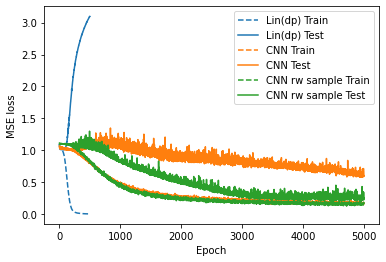

TINKER_DNA_CNN(
  (conv_net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 6), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
    (4): Conv2d(32, 32, kernel_size=(1, 6), stride=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=2976, out_features=10, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.5, inplace=False)
    (10): Linear(in_features=10, out_features=3, bias=True)
  )
)

In [35]:
mer8motif_cnn_rw_data_label = [((mer8motif_train_losses_cnn,mer8motif_test_losses_cnn),'CNN rw sample')]

tu.quick_loss_plot(mer8motif_lin_d_data_label+mer8motif_cnn_data_label+mer8motif_cnn_rw_data_label)

mer8motif_model_cnn

Running CNN
Running CNN
Running CNN


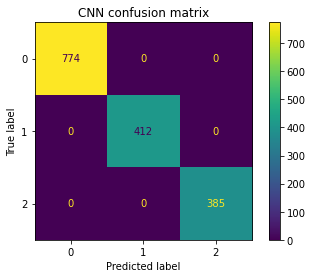

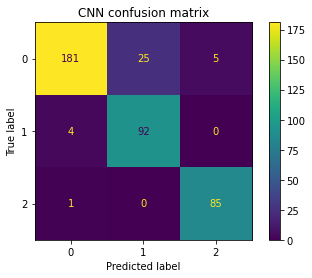

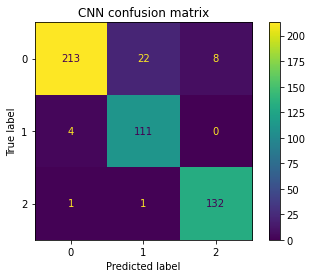

In [42]:
models = [
    #("LinearDeep",mer8motif_model_lin_d,DatasetSpec('ohe')),
    ("CNN",mer8motif_model_cnn,DatasetSpec('ohe')),
#     ("Kmer1_8mer",mer8motif_model_kmer1,DatasetSpec('kmer',k=1)),
#     ("Kmer3_8mer",mer8motif_model_kmer3,DatasetSpec('kmer',k=3)),
]


train_seqs =  train_df['id'].values #val_df['locus_tag'].values #
val_seqs =  val_df['id'].values #val_df['locus_tag'].values #
test_seqs =  test_df['id'].values #val_df['locus_tag'].values #
task = "6mer_motif_reg"

oracle_syn = dict([(a,[b]) for a,b in syn_df[['id','reg']].values])


dfs_train = plot_confusion(models, train_seqs, oracle_syn,[task])
dfs_val = plot_confusion(models, val_seqs, oracle_syn,[task])
dfs_test = plot_confusion(models, test_seqs, oracle_syn,[task])

In [37]:
cnn_res_rw = dfs_val['CNN'][1]

cls_report(lind_res,"LinearDeep")
print()
cls_report(cnn_res,"CNN")
print()
cls_report(cnn_res_rw,"CNN RW")

LinearDeep (acc=0.438)
micro: p=0.438	 r=0.438	 f1=0.438
macro: p=0.377	 r=0.375	 f1=0.375

CNN (acc=0.796)
micro: p=0.796	 r=0.796	 f1=0.796
macro: p=0.790	 r=0.780	 f1=0.784

CNN RW (acc=0.911)
micro: p=0.911	 r=0.911	 f1=0.911
macro: p=0.901	 r=0.935	 f1=0.914


In [47]:
mis_c = quick_classify(mer8motif_model_cnn, val_seqs, oracle_syn)

117: pred:0 actual:1 ([3.0275962352752686, 2.5831143856048584, -5.593941688537598])
267: pred:2 actual:0 ([0.7230398654937744, -2.011707305908203, 1.352453351020813])
320: pred:1 actual:0 ([0.5190050005912781, 0.5225489735603333, -0.7975653409957886])
392: pred:2 actual:0 ([0.7581949234008789, -3.5918731689453125, 2.7555389404296875])
414: pred:0 actual:2 ([2.914363145828247, -5.496156692504883, 1.9381752014160156])
426: pred:1 actual:0 ([0.5184739828109741, 2.069629669189453, -2.526233673095703])
575: pred:1 actual:0 ([1.7846301794052124, 3.62437105178833, -5.685311317443848])
637: pred:1 actual:0 ([1.1859190464019775, 4.679647922515869, -6.202211380004883])
768: pred:2 actual:0 ([0.9892491102218628, -2.2868642807006836, 1.3319653272628784])
829: pred:1 actual:0 ([1.012656807899475, 2.3897275924682617, -3.3602190017700195])
889: pred:1 actual:0 ([0.40317851305007935, 2.3042702674865723, -2.6332144737243652])
895: pred:2 actual:0 ([1.4423524141311646, -3.274685859680176, 1.737267971038

In [50]:
for x in mis_c:
    print(f"{x}\n{loc2seq[x]}")

117
TCACGGAGTCGTCTCAATGCATCCTGATCCCAGGATGTAAAAGCAGATCGTGAATTGTTTGGAGCTGGGACGCTGTATACGATGCCTCGGTGCTTGAGGCTCACCTTACGCCTTACACTCCCGCACCTTGCCAAGGCGAGGGTACTTATACACTCGATCTATTGGCGAGTGTGTCCGTCTATGTCGGCCCAGACACGAGTTAGAGCATCAACAACCGGCCCAACTTTACTTCCGTGCGTACACGGAGCAATTGCAGCTGAGAATCAAGATTACAACTCGTGTCACTACAGGCGGCCCGCC
267
TAGGTTTTGGGCGCTATGTCGGCTTGACAAGTCGGCAAACTTTATAGCTGTCATCGTCCGGGAGCGAGATCGAGCGACGGCCGCATACACACGGTCAGGCACACCCGCGAACTCGGAACGCGTTACTAGTCGTTTTAGTTAGACCTAGAACGGCCAGAAGTCATTACTTGCGACGGGCCAGCTGAGGCAGAAGGGAGGCGAAAGCTAGTCGGGGCGACTGATTGATTTGCGCACCTTCGAGCAATACTGTACCTAGGCTGTCCGCAGCAATACGCGAACAGTGCTAAACGGTAAACTTGA
320
ACCCATGTCGACCTCGAGCTCCTTAACCACGCACCAACCCGACGCGCGTTATGTATTAGTCGCACGCATTACTGCCTAATCGATACTCACATGCGAGTGGAGGTTAGTCTATGGGGGAGGCAACGTTGTCTATTTAAACTGCGAAGAAAGAGTGCGTATGAGTACTGATCGATGCAAATCCCTACTTTCGCAATTGCGCATTCATGGATACGTCGAGGTCTTCTCGAAAGGATATCGTAAGGTTGCCCGATGGGACTGTTGGGGACGACAATTGCATGCAGCCACTAGGTTGGCCGCGGC
392
AGACGAAACCTGTTAATTGAGGTTCGGGCATAGTGGCGCATCGAGACACAAGCATAATTTCCCGTGAATAAGGTCAGATTA

# filter viz

In [38]:
def get_conv_layers_from_model(model):
    '''
    Given a trained model, extract its convolutional layers
    '''
    model_children = list(model.children())
    
    # counter to keep count of the conv layers
    model_weights = [] # we will save the conv layer weights in this list
    conv_layers = [] # we will save the actual conv layers in this list
    bias_weights = []
    counter = 0 

    # append all the conv layers and their respective weights to the list
    for i in range(len(model_children)):
        # get model type of Conv1d
        if type(model_children[i]) == nn.Conv2d:
            counter += 1
            model_weights.append(model_children[i].weight)
            conv_layers.append(model_children[i])
            bias_weights.append(model_children[i].bias)

        # also check sequential objects' children for conv1d
        elif type(model_children[i]) == nn.Sequential:
            for child in model_children[i]:
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
                    bias_weights.append(child.bias)

    print(f"Total convolutional layers: {counter}")
    return conv_layers, model_weights, bias_weights

def view_filters(model_weights, num_cols=8):
    # squeeze for conv2d??
    model_weights = model_weights[0].squeeze(1)
    num_filt = model_weights.shape[0]
    filt_width = model_weights[0].shape[1]
    num_rows = int(np.ceil(num_filt/num_cols))
    
    # visualize the first conv layer filters
    plt.figure(figsize=(20, 17))

    for i, filter in enumerate(model_weights):
        ax = plt.subplot(num_rows, num_cols, i+1)
        ax.imshow(filter.cpu().detach(), cmap='gray')
        ax.set_yticks(np.arange(4))
        ax.set_yticklabels(['A', 'C', 'G','T'])
        ax.set_xticks(np.arange(filt_width))
        ax.set_title(f"Filter {i}")

    plt.tight_layout()
    plt.show()
    
def get_conv_output_for_seq(seq, conv_layer):
    '''
    Given an input sequeunce, get the output tensor containing the filter activations
    '''
    print(f"Running seq {seq}")
    # format seq for input to conv layer (OHE, reshape)
    seq = torch.tensor(u.one_hot_encode(seq)).view(-1,len(seq),4).permute(0,2,1).unsqueeze(0).to(DEVICE)
    # OHE FIX??
    # run through conv layer
    with torch.no_grad(): # don't want as part of gradient graph?
        res = conv_layer(seq.float())
        return res[0]
    

def get_filter_activations(seqs, conv_layer):
    '''
    Given a set of input sequences and a trained convolutional layer, 
    determine the subsequences for which each filter in the conv layer 
    activate most strongly. 
    
    1.) Run inputs through conv layer. 
    2.) Loop through filter activations of the resulting tensor, saving the
            position where filter activations were >0. 
    3.) Compile a count matrix for each filter by accumulating subsequences which
            activate the filter
    '''
    # initialize dict of pwms for each filter in the conv layer
    num_filters = conv_layer.out_channels
    filt_width = conv_layer.kernel_size[1]
    filter_pwms = dict((i,torch.zeros(4,filt_width)) for i in range(num_filters))
    
    print("Num filters", num_filters)
    print("filt_width", filt_width)
    #print("filter_pwms", filter_pwms)
    
    # loop through a set of sequences and collect subseqs where each filter activated
    for seq in seqs:
        res = get_conv_output_for_seq(seq, conv_layer)
        # for each filter and it's activation vector
        for filt_id,act_vec in enumerate(res):
            act_idxs = torch.where(act_vec>0)[1]
            activated_positions = [x.item() for x in act_idxs]
            # get subsequences that caused filter to activate
            for pos in activated_positions:
                subseq = seq[pos:pos+filt_width]
                #print("subseq",pos, subseq)
                #subseq_tensor = torch.tensor(u.one_hot_encode(subseq)).view(-1,filt_width,4).permute(0,2,1).squeeze(0)
                #subseq_tensor = torch.tensor(u.one_hot_encode(subseq)).permute(0,2,1).squeeze(0)
                # OHE FIX??
                subseq_tensor = torch.tensor(u.one_hot_encode(subseq)).T
                # add this subseq to the pwm count for this filter
                filter_pwms[filt_id] += subseq_tensor            
            
    return filter_pwms

import logomaker
def view_filters_and_logos(model_weights,filter_activations, num_cols=8,ysc=1.0):
    model_weights = model_weights[0].squeeze(1)
    print(model_weights.shape)
    
    assert(model_weights.shape[0] == len(filter_activations))
    # make sure the model weights agree with the number of filters
    num_filts = len(filter_activations)
    num_rows = int(np.ceil(num_filts/num_cols))*2+1 # not sure why +1 is needed... complained otherwise
    
    plt.figure(figsize=(20, 20*ysc))

    j=0 # use to make sure a filter and it's logo end up vertically paired
    for i, filter in enumerate(model_weights):
        if (i)%num_cols == 0:
            j += num_cols
    #     print('i:', i)
    #     print('j:', j)
    #     print('i%8 == 0', i%8 == 0)
    # #     print('i+1%9 =?', (i+1)%9)
    #     print("i+j+1=", i+j+1)
    #     print("i+j+1+4=", i+j+1+8)
    #     print("*******")

        # display raw filter
        ax1 = plt.subplot(num_rows, num_cols, i+j+1)
        ax1.imshow(filter.cpu().detach(), cmap='gray')
        ax1.set_yticks(np.arange(4))
        ax1.set_yticklabels(['A', 'C', 'G','T'])
        ax1.set_xticks(np.arange(model_weights.shape[2]))
        ax1.set_title(f"Filter {i}")

        # display sequence logo
        ax2 = plt.subplot(num_rows, num_cols, i+j+1+num_cols)
        filt_df = pd.DataFrame(filter_activations[i].T.numpy(),columns=['A','C','G','T'])
        filt_df_info = logomaker.transform_matrix(filt_df,from_type='counts',to_type='information')
        logo = logomaker.Logo(filt_df_info,ax=ax2)
        ax2.set_ylim(0,2)
        ax2.set_title(f"Filter {i}")

    plt.tight_layout()

Total convolutional layers: 2


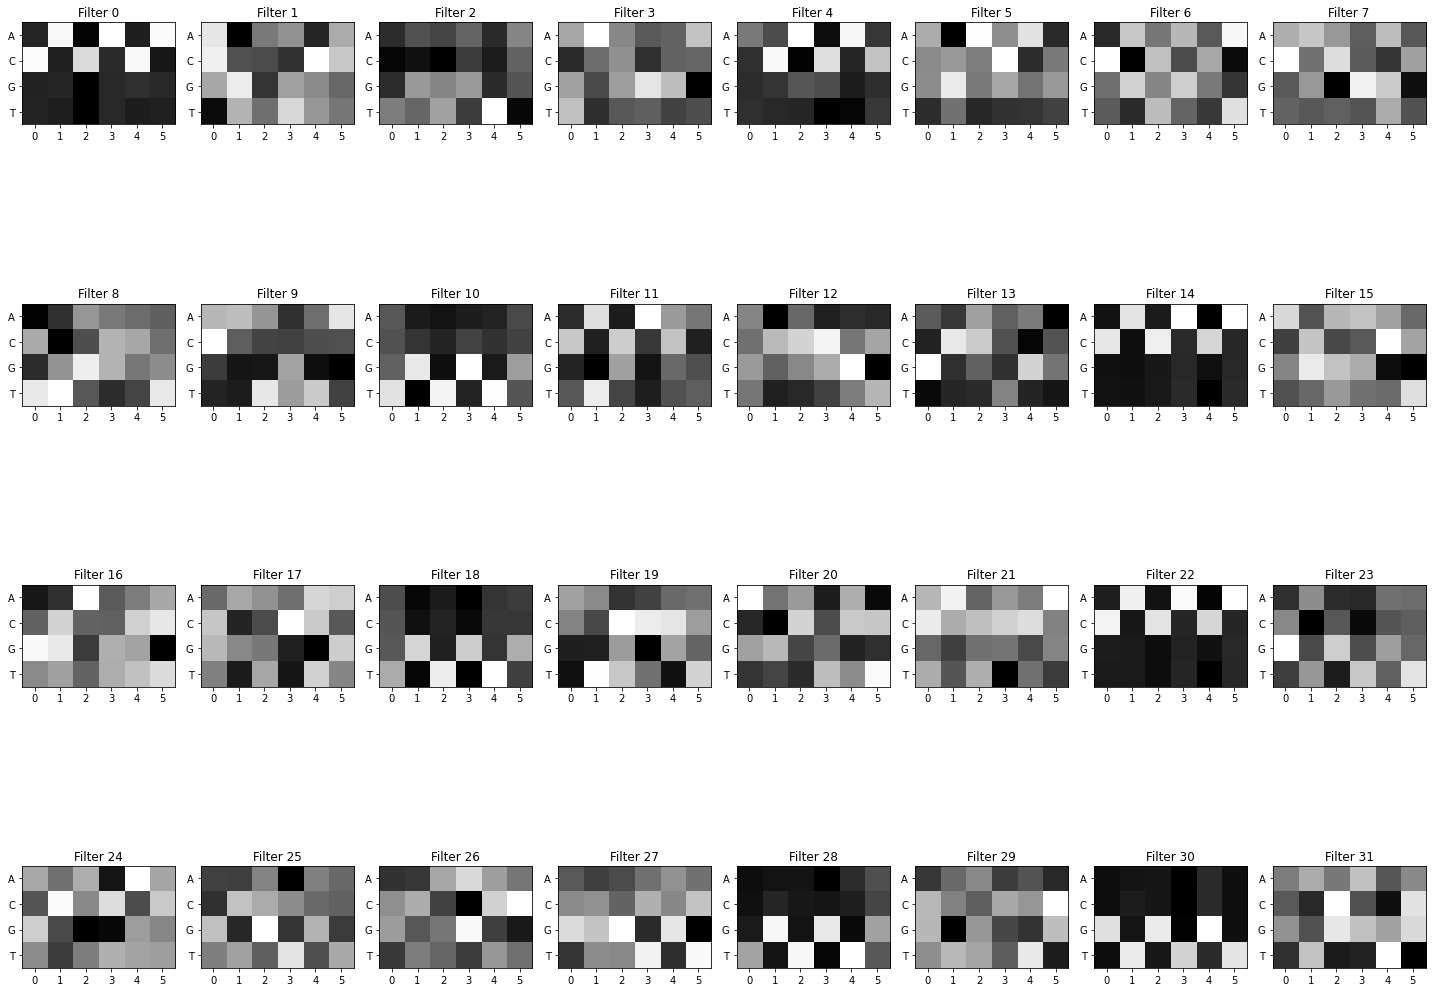

In [43]:
conv_layers, model_weights, bias_weights = get_conv_layers_from_model(mer8motif_model_cnn)
view_filters(model_weights)

In [44]:
seqs = [loc2seq[x] for x in train_df['id'].values[:500]]

filter_activations = get_filter_activations(seqs, conv_layers[0])

Num filters 32
filt_width 6
Running seq TTCAGTTAATTAGTAATTCCTACAGCGCTAGAAAAGTGCGTGGATGAATATTCGCTATGACAGGTTTGGTTTGGGTCTGCCACGCAATGGGAAACTTAGCGGCTGTACGTCGTGTGTACGACTTCTTCTGCATAAATCATTTGGAGGTCCCCGGCGGAAGCGGCACCCCGGGACTTCTTGCTCATACAGCGTTTAGATGCGACCAGCTTTAACGGGTGGTGTCTGAGGTTTGCGGTCGCCTGAGCCGCCGCAGCGAGGCAGCCCCCATTGATGTCATCGGTTCGGCATCCTATCAATCCG
Running seq CAGTGTTTGCGCTTCGAAGGGACTGGACACGGCCGAACAACTATCCCGAGTACGACACATGGTCAACTGGCAATTTAGGATCTGGGTCAAGCTGCGCCCTTCCAGCATATAAATACCTAGGTTTTAGTGAATATTACGCGACTACTCTTGTCGAGGATTAGCGCTAAAATTTTTCCACGCCTTGCCGTAATCCGTCCAGAAAGGCCAACTTTTCTGTACGAGGACGACCTTACCCTGTTAGCGCCAGGGCCCCCTGATCTCTCTGATGTCTGTTTCACAATCTGGTGATATGGCATCGCG
Running seq ATAAAATCGCGTTTTTGTATCTGATTCAGCTGCCAGGGAACTGGGACCTTGGGTTGCTACAGTCTAACCCCCCAGCGCTGACTGAGAGGCGTCCGGACTATCTAGCATCACCTAGAACGTTTCAGCTCACAGATACTATGGGAGTCGCTCTTATGACCCTGGGTTACAGGCAAACCTACTGTGCCCATTCCGGGTTACGCCACTCGGCTCGCACCGAAAAGGGTGAAGGCAGTGGAGAACGTCAGCGTGATCATTACAAAATTACAGGACGCTAGCTCGACGCGCGCCCACACGAAGATG
Running seq CCTTCGCATTCCAGTAGACTA

Running seq TCCCTGGCGAGACCCTCTACACGTATGCGACGGTGCGCCCAGCCATTCACATGCGCATTCCCTCTATAATCCAGGCGGATTTTCGCGGGTTCGACCCCCTTGCTTTCTCTCAGTGCGCGGACTCTCTAAGATTGGCATATGCCCCGCCGACATGAAGGAGCCAAAGGCGAGTTCTGTAAAGTGGTTCTGTCAATCAGAAGGTACGTTTCCTGGACCCTTAATACACGAGCGTCCAAGGCAGCTCGTTAGTCTAGGAGAAACGAAATTACCGAGTAGAAAATACGATACAATTGTTTGTTT
Running seq TACCCACCGACCAGAAGTCGAGTTGTCGCCAATAAACAGCCTTTAAAAGAAATATATAGTATCTCGTTTCATGTCCGGGAGGGGCCAGGCAACTATGGGCCAGGTTCGCCCAATATGCAATCTCTAATGTTTCTATACGGCCTGTCTGTGCCCCGACGCTGTTCGCCGCTTTGCCGTACTCCATATTAGTGGAGCCCTTCAGCACTCAACATCACAGCCTTATCAGTCGGCTCGACCCCTATGTGAGAGGCGTATGCTGCACGGAGTTTGAATGATCCCCGTGCTCTCGTACTCCGCCCA
Running seq AGCCGGTGTAAGATGCCCCAGTGCGTGTATTATCCTCGGGCGATGTCGTACATCCGTAGTTTCCCCGACTTGAGTCAGCACAAAATAGATGGACGTCAGGGGAGAGATATCATATGAAGGAAATCACAAGACTCTGTCGTACATACACGAGACTGCTCTTTCGAATAGCTCCGCCCCGTCAAGAACCATGCAAGGGTGACCAATCAGATGTCGCTCACCCCGAAGCTTATAGAACTAGAAAGCGTGTGGCGACCTATGGCTGGCCTTCTCAGTTCCTGAGATAAGCTAAAATTGTTTCTT
Running seq GACATTTGATGCGCGACTTAGGCTGAACGTCTTAATACTCTTACACGCT

Running seq TTGGTCCTTTCTATATATCTATATGCAGTTTAGCCTGCACTCTCCCACCTCAAAACGAGAATTCGCTGTAATGTAGATCTTATGGCCGCTCTCAAAAGCCCAGATCTTGACTTCCAGTATCTTCGTAATGTAACTTTTGCTGCAGGGATAAAGTTCATCTTCGTGGCAGCGAATCCGAATTGATACACTCTATCGCTGCCATCGTTGGATTCTTCAGGAGGCGTTCGTGTGTATCTGCAGGCGCATTGTTAATATTATGGTTCGAACATTCTACGAAAACCCCCACGAACTTCTGCACCC
Running seq ACGCTTACGCACGGAAGTTGAGCGCCTGGCTAAGCCCGCAATGCGTAGTTCCAGTGTCATTTCATACAACAGTGGTTCACCGAAAAGTATCTAGGGGCACCTGCCAGACTCCCGTTCCCTAAGTTCTATGTAATGCTGTCTTGACTCTCTCCGATGGCGCCGTATAAGTTAATAATTGTGAACAATATTGAGACCAATAAATCTCAAGTACAAGTCTACACATTGGGCCTGGAATATGGGAGCAGGGCGCGCTCCGTAGCACTGTATTTGGCCGTGTCCATTAGAACGGAGTATCCGGGT
Running seq CTTACTATTTCCCCGGATCGTAGTCGGACACCGAAGAGGACTGATTGAGGAACTGTTGACGTAGATACGACGGCGCGAAGGTTCGTGACAAACCCTGCCCGACCTAAAACGTGCACGGAAGCTCTATATTCCGACTGTTGACCCGAACGGAGTGTCGCACGCTATGGTGAGTACGGAGTGTCATCATAATAAAGAACAAGGCAACACACCTTCGAGAACAGATCTGGTAGATCTCACTCATGGCAATTCGGCATGATAACCCGTATCTTGACTTCGTATCTGTCCCTGCGTTCCGTGTGT
Running seq CCTGCGGCTGAACCTTCTGACGTTCCGATTAATCCATAGATTTCTAAGG

Running seq TAATAGTACCGACCCCTGAGAAGGAATTGTATACATGTGGGAACGCGAGCACATGCGCAGCGGTTGTCAAATACTGCGCCCCAAGTTAGAACAAGCGATATTGTCGAAGAAGCAACACAGCAACTTATGTAAGTAGACTGCGAATGTGCACAGATCTAAGGTCGTATCTCGACTCTATGCCTAGGGAGTCCAAGCTCAACTTTGCCGACACATCGCTTAAAATTAATCTTTCGCGCATGAGTAGTATGTGTTCGAGCACTTCAGGCAAGGAGATAACGCCTCGTTAATATTGTCAAATCA
Running seq ACCCTCCTTTGCTGGACCTATAAGACAAGACCTGCACGTCGCCGATCAATTCTATCCGAATTGCTGAAGCCCGGCGGAAGAGAGAGGATGTGGAACAAACTATGCGATCATATGAGGGTCGAGCCAATTGCTACAAACCCCGTGAGTTCCGCATGAGGACCTCGGTTGTATAAAGATCTATATATCATACGGCATCTATTTAGGTGATACGCTATTTAGAATAGGCCCTAAGCCTTTGAGCAGGCGTAGTTGGTGTGTGGCGAGTCCGGGGCAGCCTGGCTCTTCGTGAACTAACAGGTC
Running seq GTCTAGACACGGGGCATACCGGCATTTTGCCGGGGGCTTAGTGATCCTCTTTCTTAGATGAGTGTTAGGGCGATCGATGTGGGCACATCTTTCAATCGCACGATATCGTACCTCACATGTCGGTGGGCCTAGGCCTGCTATAAAAAGATATTTGGCACAATCGCGCGTCAAACGAGCGCGGAAAGGAGGTGGGGGGTAAAGACTCTCTTCCCGGCAAACAGGTGTTATGCGGGGTCCTAAGAGTGGCCTTCGAATTTAAAGGCGCGTCATGCGGTTTGAGCATGGTGAAGGAGAATTCTA
Running seq AGGTCAACAGGTGGTGCGATAGTTATTAACACGATGCGGTCGAGGCTGA

Running seq TAGATGCCGCTATTGTGATACTGTCTATAACACAGAAAGATACTACACAGCACCGGTCAGACATAACGATTATTTAGAACGCAGTTGGCTCTTAGGATTTGCTACGCTAATGGAACGCTCATCGCACCCAGACTTAGGAACTTATGACGATGCAAGTAGGCTCTTAAGGAGGATCAAGATGTTACAGTTGACGGGCTAACCTGCATGGAGCATCCAGCTCCCGACTTCTTGGAGTACATAGAAGAGTCCACTCGAGACACTCTTGGGCCTCAAGGAGTTTGTACCTTCGCTCATAATACA
Running seq AGACAGACTAAAGAGGAAAGCTAGATAACAACTTCGCGAGCATGCTTACTCCGCAGCGCATGCTCACTAATCTTTTCCGGCCAGTGTTGCTTCACGAAGACAGTAGCCGGTACTCGCATTTAGACTTCACATGAGCCATTATATTCCTTTGTGTCACTTTATACGCAACGTCGTTGCTGCCATTAATCAACTAATTAACAGGGATTCTGCGTGCCCGCCCGGATCCTCCTATCTTAAGCGTATATTCGATTACAAGTATGGATTGTAGGGGGCTGATATGGCCGTGCGTCGTGAGGCCAA
Running seq ATAGTCAGCTTTCATAGTGGATTACTTGGTTACCTAAGGCCCATCGCAAATCGTAGAGATTCCCGGGCGGTCGCGTGTTGGTGTTATTCGGATTATACATGAGGCGGTGGCGTGCGTGAACTCTCATTTGGGTTGACTTCGGTCCGTGAACCCAGAGGAAGCAGGCCGTCGGTTGAGAGCGAAAGCTGTACCTTGCATCAACCTGGGTCTCGACTCATCCCACCGTTCTCCCCTCAGGCACGGTTTCAAACTAGGTCTATACCGTAATGTGCGCGAGTAACCTTGGTTTGCAGGCACCCG
Running seq TGCTATACGACCACGGGGCCCTTAATTTGCTGTCTGAGATCTCGTTGCA

Running seq TTGGCCCTTCGGGACGGAGCGACGCGGTGAAGGGGTCGCGCGTTCGGATGCTCCCCATTCGACGGCCCTTCCTTTGTGCCATAAGCAGATGCGCACCTTATGCACACAATCCCACGCCCTTTGGACCATAATCAACAGAGCCAGCGGTTCGGGCCGTAGTATCAGCATTGCAACCGAGGTTGCACGAGAGCAATAGCCCATTGCGGTACACGTGCAGCTGATGTATCAGCGTGGCCCTACACCTGATAAAATACCAAATCAGTCCCCCGCAGCAAGCCTAACGTAAAGTTGTCGATATGC
Running seq ATGGCTAAGGTCTGTTCTTCAGATAAAAACGCCTAAGGACGCAAGATCTGTTCATTCGTAAGTCTCCGCAGAACTCTGGTCCTTACGACAATGACTCACTGGACAGCAAAGGACAGGGGTGTGTCCCCCTACATAAAAGCATCTATCCTTTTTTAGCCCATAAGCCTCCGCATACACAAAGTACGCACCCAAGAAGTATAAACTCGGTAGTTCGCATTTGAACACCGACCCATAACGGCCATTTATCATTAAGGTATATGAGAACATAATGCGACTGAGTGAACTCTGTGTCCTTTGTAT
Running seq TAATTTGATAAAAGTACCCGGCGGGAGTCAGTGCGGACCTCGGAATCATCCCAATAGATCTAGTGTGTCGTTTTAGCTAGCCACCCATGGTATAAAACATGGATCACATAAAAAATTCTAGCAATTCTCAGATGGGGAAGCAATTCTTCCCCCGGCTCCTAGTCCAAGCTACCAAGGAAGCTATGGATATCGTATGCAGACACCCGATGAGTAGTTACGATTGTAGGACTATGATCTGCAATATCTCGTCGTGAGAAGGGGGTGCTGCGAAAAAAAACCGCACGGCCGCACTAGGGCGAT
Running seq TAACAAGGCGTCAATGTCATTTGGTTGCGTTGGGCCTCAGTCGACTGAG

Running seq GGCTAGGCCAGGAATTCTTAGGAAAAGTCATCAATCCAGGGCCCTCTTCCGTCTCTGTTTCACGGAGATTAACGCGAAGAGAAGGGTTGCCTCATGCCAGTAGTACTGCGAATCCCTCTTCGCGGACCTGCTAGTTATGAAGCACAAACGATATGGGAATAACTTCACAACTGGATATGCCAGTGACTTCGGTTCTATCGAATCTGGCCCTGCTCGTGTGAACCATGCTGACTTAACCCTACCAAAGGCATGCTAGGTTACCCAGGTGGTCCCCATGGCTTGACGGGTCTTATAAAAGGC
Running seq TCAGATTAGCTCTCGCCATCAATGGATCCGCCGCATCGCGCAAGAAGAGTAGCTGTGAGAAGGAACTCCAGCGCCGGACGTAACCGTAGGAATGCTTAGGCAAGCTTTGAAAGTTCTCAATACCTACCTTATCCGTACAGCCTCTGACATGAGACCGGGAGAATCTACACAAGCTTATTTTGCGAAAAATTGCCAACCCCCGGCCGCCTGTACGATGAGCATACATAGCGATAACCATGCAGGAACGCTGCATTCCTTAGATCGAGTGATCGACGTCCTCATTGGGTAAGTTCCACGTTC
Running seq AATCTGACTTACGACCCACCCGGCCTTAAAAGTGTTGACTCTGTTCATAATGCTTCGACTGCGCCCTCTCCCGCGATGCCCCCTCTGCGGTCTTATCCCGTGGATTGCCCCGCTGCGGTGTATTGGTTGTTAAGTTGATGAGAAAATATCTATTTTTAGAATCAATACACTGGCGCCGTCACTTGTCGCACAGTAGTCAATAATTGACTATTATCTCGCATGTCTCTAGTTAGATTTTTTGTTTGCTGGGCACTGCCATTACTGTACACTAAATATCCCTTATGGGCTCCATGCTTCGGC
Running seq GCCCAGACGGTCATGTTCCTGGCTGCTTGCGAGGGTCTATCACGGGCCA

Running seq GGCGCCTCGTTCCTTGTATAACTGTGGAAAGATCACAGATGGGTTACAGGACCCGAATAACTTGTCTTGCCGAAGGACAAAGCTTCTTACAGTGACGCCTGAGAAGCCTTGACTTTACCGGGGAGGCGGCAGGAACTTCGTGCGTTTTGTTTCGCCGAGGATATAGGAGACAGATCGGAATCCCTGCTCATCACACACAGGGGCTAGATGTATACTCTTGATCGTAGTAGCTAAACTCGAGACTCACGATTTAGAGTTTCGCTAAATGAAGACTGGACCCAGTGCACCGGGCGTACACTA
Running seq GCACCTACATGTTTGTCCCTTTTTCCTCCTCCTCCACTTCTAAGCTTTCAAACTAGTGGCGGCAAGATTCTCGGAATCTATTGAACGTCGCTCACTAAGCCCACCGTGGTGTGTGGCGAGCTTGCCCTCGTCCTACCAAGGCAGATCTCGAGGTACCGTAGAACAAAGAGGCTGGTGCCTTCCCTCGCACCTCCGCAGCATCAGTGGTGTGATCGGAGTGGATCGCACTTCAGGCTATTCTTTCTTACCGACATTTATGTGAAGACATCAGGTTAGTGTTATCAAGTCGTTAAGTTGACA
Running seq ATGATGTTGGATATTCTCGGGGTGAACCAGGGTCCACGTTCACTGCCAGTCTCTCGGTGTAAACTAATCGCCAAAACGAACTACTGCGGAAAGTAGGTTCGCCTACTCTGAGTTATTTATTACCCGTTAGACCGCCGACCTCAGCGTAAGTGAGAGTCATGCGGCAACCACAATCGTCCACTTTTAGTAATGTGGAATGCTGTAGAACATGTCACATTCTCGGCCTCGCCGGCACACATGGTGCCTCGTCGTGGCTTGGGGGGCTCCTTCTCCACTCTAGTCACGTCCTAAACTCGAGTT
Running seq ATATCGTGGGTGTTCGCCCCCGATCTATCCGAAAGTCACTTACACGTTC

Running seq AAATTAAAGCCGTTAGCAAGTGAACGGGTTAACCGAACGGTATGCCCTGCTTCTCTGTCTCGTGAAGCAAGGATTTCTCAGTACGATGCCCACCTGAGCACACGGGTCGTAGGTGTTGCGCGGTATCATCCCTTAGGTGGAGAGTCTAGCCCTACTCAAGGTCCCTACGTGATTTACAGACTGCCACCCGTAGAAAAGCCATAATGCCCTCCGATGTTTGTGCAAGGCTATATTCGCGTTTGGATGATTTATACAAATCGGCGACCAACGCTCGGGCGTTAACTAGCTTACAACCACGTT
Running seq CGCACTTATTGAGGCAGCTATAGTCGCCAATGGCAAATATATCCGAAAATAGACCGTATATTTACAGTTCATCCGCCCTTATCGAAGCGCGGAGGGTGGACTACACCCGAGACACCTCGGTCGCCAACAAGTGCGTTACAGCCGCACATTTAGTGGCGGAGGAAAGTTAGAAAGCGTTCCCGGAGCAATGCCCCTAAGGACAACTGTGTCGGCGGAGGCGACTCAGCACAAACCCAACCACGATTCGCTTGTACTGACGCTCAGTCCGGCAATGCTGGATGTTGTAGAGATTTGACATGC
Running seq GCCACCTCCTCCTTTAACTGTTGTGTGCGCTTCGTGAACTCCTTTCGGCTATACAAACGTTCGGAAAGACACATAATTTCAGTGCGCACAGTGGGATCCGCAGTCTGGTCTAAGGAAATTGCCCGGTCCCTAGCGCACGGGAATGAGACATCTCAAGTCGGCATAATCGTAATGGGACACTCCGAAGCTTCGCTACCCTCCAGTAAACAGAATATCTTTATCGATCTGATCCGCCCCAACATAGTACTGTACTACCAAATATTCATTGCGATGGGGAGGGTATTCAGGCAAACAGGGCGA
Running seq AATTGCAGGGGTGGCCATCAGGGCTCGACAAATATTTACCACCATTAAA

Running seq TTCGCTTGTCACACACACGACCATTGGCCCGTTCGATAACCATCGGCTTGCGCGATCGGCGTTCGGCAAACCGCGGCACTAATCGGGCAGGTAGCAATATAGAGCTCCAGATAACGCAAGGATGATTGCCACCTCTGACGTCGCATCCCTCCTGCAGTGCGATTAGGCCTAGGGTCTTGTTTTCAGAGTTGAGGTGGAAACCAGTGCCGGTAACCTGCCCTAATGTGTCAGTACCCGTACGTAAAAGGACGTTTAAGGTGGCGAACTCGAGGACGAACCACACCTCATTCCGCTTTAATT
Running seq ATGATGTTTAACGGTGGATGACGTCGTATGGCGAGGCTAGCGCCCTTTGATTTGACCCGGTGATGGTATAGGAATATAGTCACGAGGGAGCTATTACCCGGTCGTAGTACGCAATGCTCGCGCCAGTTCCTTTCATTGGACTTTACGAGCCGTCCCTATGAGAATTTTCCGATGAGGTAATCCCCTCGGCGCCAGACGCCTCAGGAAATTAAAAGCTTCAGTATCACAAGGCGCCCTAAACCAACCAACTTATGCAAGGGTCGCATAGGGTCCCCAAAGCCGGCGCAATGACGACGGGTT
Running seq CTTCCGTAGCCATGGAGTCGATCACCCTACTGCTCCAAATCGCGTCGGTTATAACGGCTCCGCGTACTCAGAGAGCCATAACAATCAATTTGAGGATGTACATTGGTTCATACACGCTGACCTGTTCCGAAGCTAAAGACTGGACTGGACACTTCTGCATTGATTACAATGTTGGCCAGGCTTTGAGCTGTGCACATGTTCGGCGATTTATGACACAACGGCGGTGACGAAAGGTTGGGAAAATCTTAATATGGCAGTTTGTGCTGCATGCTCAGGCCGGGAGGCGGCAAAGACTAGAAT
Running seq TTTACCGGTGGATTGTGTATAGGATTACAGGGTAGATAGCACGCTCCCT

Running seq TTGGATCACTCCATCCACGACCTGCACAAACTGTTGGTTCCTGGTACTGTGTGCAGCAGATTTACCATATGGTCTTCTTAACCACCCGCCGATACCGAACGGGCTCGAGGCTTAAACGGCCCCCGGTCTTTCTGAATAAAGGACTACTGATTGGTGTGTAAGGGATTAATGTGTGAGTCCCCAGCATGTCGCCTCGATGCCGATGTAAACAATTCGCCGCTTTACAAAGTACATAAATTTACACGCTCGACCGGTGGTCTCGTGGATCAGAGGCTTTGTGAGGAATCGTGGTCTAGCGAT
Running seq CTAAGTGAGGGCGATTTGTTGGGATTCGCCGGACATGATTTACACACAAAATTAAACTTTAGAGAATATATCAGACAACTAAAGAAGAGGATCACATCGCTATGTGATTAGTACTGCCAACAAAATCGATTGGACGAGCGCGGGTTCGTTGTGTGGTACGGTACGTCTTATACTGACCCATTTCGGCCGCTCCACCTATCGTGGCGCGAATCAGTACGGTCGTTTGATGGTTTTACGCGCAGGAAGTCGCAGCTCAGGCGTACGGGTTACATTCACCAGGCTGTCGAGTGAAGCCTGTGC
Running seq TCGGTGACTCTATCTTCACGGCTGCGCTATCCCTCGGAATCCTCTCTCCGCGCAGACGACTAGGGACCAAGATGCCCTGCGGGAACTCGAGGGGTTAACGTGTACTGCCCAGACTAGATTAGCGGCTACCAGAGAATCTAACATCTAAGTTAATTTCAAGAGTTTAAACGTGTCGTGCGAGGAAGGCACACAGTACGTCAACTGGGGATGACTCGGAGTTCTTTGGATGTATGTCGGAGCCTGCGAAATAAAAGTGAAAGGCTTAGCTGATGTTGATTCATCTGATCTACATCTCGTAGT
Running seq AGTCCCGCTGCTTTTTCTTGTCATGAAGTGTGTTTTTCAGAAGGTAGAT

Running seq CGTAGTGGCGGATCACGGTCCCACTAGTTAACGTTCCAACACCGTTTATCCAAATCTACGCTGCCCCAGACCGACTCTGGGTGGCACCGCCGTCCCTTAACAAAGATCACGCACAGGCCGGACTCCCTTTATCTTAATCAAAGCAAAGATGTCGATTGCCGCCAGGGCAGCTTTAGCTTATGAACGAAATAGATGGTTTGAGGCCCTTCCGTGATCGGTGTATTACCGTCAAATTGAGCTTCGAGGGTCTGCCTAGGCCTGAGGGCTTACCTTATGCTGTTCGAGCGTTCTCATCCCAAC
Running seq AGTACGGACAGAATCGACTAGTGCCAATTTTCTTACTCGTACTACATGTTTGCAGCGTCCAAGTAATCGGTCTCCGTTTGTCTCTGCCATTGTTTTCATTCCGCTACATGCCCAAAAGGGCCATAATTGTAACGTGGTGCGGCAGTGGGATGTGTGGTCTAGGAATACAGGCGGCAACGTCAAGGAAGAGGTAACTCTTATCGGTTTAGCCTGTCCGCGAACTGTACTAGGCGTGGTGAAAACGGAAACCACTGGGTTCACGGCAACTAATTTTCGGAGACAATTATTCAATTGGGCGTG
Running seq CATGGAGGCGTCTGGGGGGCGTAGCAGAGTTACGCACATCATTGTTGATGTCCAAGGGGCCAGTCATGGCTTAGCTTCATTTGCGGTCATGTTCAATGGAACTCTTTATGTCCCCGCTCTCTTAATGGTAAACGTACTTGGGCACGGATTTTCGCATACACTCTCCCAGGAAGCGCGCAACTATCTTAAGTCTAGATGTAGAAGCTGCATACGGCTATGAAGGCCTGCATGGGTCATATACAGATCCGGCCTAGCCGCCACCGGCAGCAAGGCTAGCAGCTAAAAGGCGAGTACTCTATG
Running seq CCAGCATGTGGCTAGGGTACTTTTATAATCGTTCTTGGCTCGTATTCGG

Running seq ACTTTGCATCTCGGGGGCTTTGCCCAAACGAGGGCAAACGGACTAACAATCCAGAATGCTACGGACCAAAGTGCGATTAATGGACAACTTGCTGGATTTTCCGTACGGTTTCCGACGAGGGCTGCTCGAAAGTTTTCAAGGAGACCCTGCCGTCACATATACTGTCCCCTGCGAAGAAGTCCTCCCTAAAACAGTCGAGAGGTTGCGTCGCTCATAACTGCGGGCCCGCGATAGGCTACCCAATGCGGCGCCCATTAGGGGGCGGTCACACAGGCTTGTTGCGCGTCCACCACTTACCGG
Running seq ATTCGCGCTTAGAAGGTACAGCAGCGCGGGGCTAGGTCCGGAGTTGTTGGTGGTCTGGGGCCGACGCGGAGCTTGCACGGCAACTATTCTTGGAAACGCTGGTCTCACAACGCCCGCTCGTTTATCACTAGGGCTCGCATATATGACAATAGCCATAACCATGGCTTCTCAATGAATATGATCACCACGGTAGCGGCGGAACTGGTAGTAAGTTGACCAGTCGTGCCGAGCATGGTGGCAAAGTATTTTTGCGGGAGGGCCTCTAAACGACACAAACAAAACGTGTGTGATTCGTGGGTT
Running seq GGCTCCGAACGATGCAGCTTACACCAAAGTGTACAGAAAACAACGGGTGGTGGTTAACAGTACACTACAGAAATGTTTCTAAGATTACAGTTGTCGGTCTACGTTTGTGGAAAGGTCTGCTTCTTTGGTCTGCGTAAGGGCAGACAGTAAGTGGAATGGAACAGCAATTCCACCGCCCATGCCGACGGGATTCTTTGTGAGCCTTCGTACATCTTCTGGAGCCACTTCTTGCTGTTACAAACTTGTGATGCTTCGTGAGATCTCCGGGTTCGGGAGGTCACGGAATTTACGGTGCCAGGG
Running seq CACCGTCTTGACCCGTCGGCTTAGGCAGCCGCGTTCTGTGGAGGTAGCT

Running seq CGTAGTTATCAGACGCGGGGTTCACGCTCACGCGCCGTATTGCTGCAGCACACAAAACCCGGCGGTTGCGCATCGCTTCCATCCACAATTAACGAAGAATGTGTTCCCTAATCTCTCTGTAGAACGGCAATATGGAGTGTCGGTCGGGGAAGACCGTCCGTTATTCGTAGAAGGCGTGAACCTCGCTCTCCGAATAAAGTAGCCTACAGAAGTAACACACAGTCCCGGCCGCGTCGTAGTCAGATTCTGGGATCGTAAAAAGGATTCGATCTGGCAGATCCTGCCGGCCGCTGTACACGC
Running seq TGGCGGACACCTGAGCTCATGTTGCACGGAGTAGAGTCGATTATTTCTAGCAACCCTTCTAGATGTCACCCCACTAAACGAATCAGAATTCCCAGTGGCAGTTTTATGGTGAGTGCTAAGCAAGCAACCCCGGTTTTTAGCGTGACCTGGGTGAGAAGCACCGCAGTCCTGCCAGATTACTGGCGCCGAATGACAAGTGTATAATATAAGAGTGCCTATTTCGTAGTCCGCTGTTAGGGCTGAGGCTGGCGTTTGTTGGCGTCCCTGCGTGCCAAACCTCCATGGTATTCAATTGAAAAC
Running seq TGCCATTTAGTCTGTAGTCACGAACGTGTACCAATGGGGGGTTTCGACCCTAACGAGAACTTTTGCCCGCATGGCCTGATGGATGTGTCTCAAACCGGGCGACGACGTGGTCCGGTAATTTCTGCTTCCGTTGTAGAGGTGCTAGGTATACACCGCCAGCCGCGAACGATGCATTATCGTCCTCCCGGAAAAGAAACTGTAACAATAGTACGCAAGTGTGTGTGAGTTCCTCGGCCACGAAATAACGCCATACGTGTCCCTATGGAATTTGTGAGGGCGGGTTGCGTTATTGTGCTGGAG
Running seq ACAACCCGAACACGTACATTCTGGGAGGTGCTAGTCACGAGGAGAGAAT

Running seq AGACAAACAGTGCCTCCAGGAGCGACAGCATACAGTCAGTAGTTCGGTAATTTCGCCTTTGATCTACCTTGGATCAACAGGGTCCACCTGCATGTGCCGTGCACTGTACATGTGCCCTGCCGGTGTTAGGACTCTAAGCAAGCGAACTAGGTGCGAAGGTTGGCAAGGCAAGCTGATACGAGGTTTGACCCCTCACACATAGGACTATCGTGAAACCTATCGCATAAACACCACTGACGCCACTGGAGCCGGCAAAGTCTAACATGTTCCAGTAGCATGCTGGTTCAGCTGAGAGTATCG
Running seq CGCTACTACCATACGAGAGCGCCTCGGGCTAGCTCGTACTCGCGGGGTAAACGAGAATAGTGTGAGGCGCGTTCTAATACCTGGGCAGCATAATTCCTTGTGTGTAAGCATCAGGCGAGAACGCAAGGTGACCAGTTTCCGGCCGTGCGCGTGTCGACGGGGTAGACCTATAGACGATTGCGGAGGGATGTCGAGAGACCGTTTACAATCCAAACGGTTCTTTTGGACTCCATTAAACGGCAGTTGCCAAGAAATAGCGATCCTAGGGCCGACTTAGAAGCCTCGTTCTAAGGGAACAGA
Running seq AGATCCTCGGTTCTATCTGGGAGGGGTCAGGCTGGTAGGCCAGAGCCAACTACCACCCAGACGGGACGAACACACACAGACAAGCAAAGCACATCTTAAATTTCGGGTCTCGCCGGTGAACTACGGGGACATTTAGGGATATGTGACTGGACCCCTCCGACCATGGAAGTATCGTCATCGCCAGTTTCTTGATGCGTCTGTGCGAGGTAAAACGGTACGGCGGGAAACGTGCACTAGACCAGCCAGATAATTTAACCCATCTGCGTAAAGAAATTCATGATATTTAGAAAGGCGACCAGC
Running seq TGAATGTGGACTCATTATCAACATTGCTGATCCGCCATGTATCACCCTG

Running seq TGGTTCGTACGAAATACCAATGTTATCTTGCGAGACGGCCGCCTCATCACTAAAGACGAGAAGTCGCCGGCATTAGTAAACTACACTGCGAGGTTACTCCATGTTTTGTGTATAGGTGTACCAATCGCAGAGTGTGTGTTTGGGATCTTCGTACCTAGATTTTGAGAAATGGCAAAGCGCCTCTCGTTGAGCTGACTTGCTTTCCGTTAGCTAGAAGCATCGGAACGCGGTATCATGACCTGCACTTTTGAGGGTCGCTGATGATAGCTTATGGTTGGCTTCCAACATAGCTGGAGCTGC
Running seq CAATTCTGCAATACACACATGAATGGTTGCGGCAACACGAGTCCTGTGAGCTCTCCGAGTTAAATGGAGGAGATCACTCCGCCAGCTCCCAAATTAGTGGTTTGCGGAGACCGTCGTCCAATAGAATTCTCAACGCGGCGGAAAGTGCCGAATTACGAAACCATACTTCCAAGAATTCTTACGTTCGCGGCAACTGTCAGGGCCAACGTCGGGTAGTTGATAAATGCCGGACATTCGTTAGGGAGGTCTCATCGGATGTGTGATTCAGTTACAGCCCTTGAAGCTTTCAAGACTGGGAAG
Running seq ATCTCATTGTTAACTACGCGGGGTGTTTATACCATAAAAGGGTTTCTTGCCTAGACAACGGTCCCACACAAAACTAACCCGTTCGGTCTGCCAGAGCCTTGTACGTTGAGACGTTATTGCCGTCGCCGAAGCGTACAGAATTCTCACTCATTTGTTATTATTCTTTTAATCCACTTTCCCTGAGGTCCTACTCCCAGGTAAGTACCGAACGCCGTACCCAACAAACAAGTAAAGATCAAGATTAAGCGGCATTTAACATGTCTTTTCGGCTAACCCAGTGGGCAGAAGTCAGGGGATACA
Running seq CATTACACAGGTTGACAACAAATACTAGAATAGTTGGGTAAGAACTCAA

Running seq TCAGAAAGCAACATTTTTTTGTGTCCGGCTATGTAGACCCCGGCTACTTATATCGGAGATACATAACTCCGTGAATCAGAGGGTGTCGCGAGGGGTATCTAGATGTGGGGCGGGGAATAGTGGTCGGACAAATCACAATTTAATTCGAAGGGAACGTTCCACGAAGCCCCCTGCACCGGCTCGTTGCACATGTATGAGTAGACTTACGACGCTACCGGTGAGTCCACGTTGATCGATACAACAGAACCCGGAGCCCAATGGAGCTTGGGGTACCTCGGACCATTCTCTCATCTACGCATT
Running seq GACGCCCCAAAAGGGTTGGGGCATTCATACCCTCCGTTCCGTGTTAGTAATTTATAGCAAGTACTATTGAACCAAGCAAAGGATGGGATAATTGGTTTGGTAGACACGCGTATATGCGTTCGATGCTCTAAGACTCAAAAGTAGCAATGTGGGCGCCGCTAATCTCTGTCAGTGTGTATAGTGGAAATCAGCGCGAAATAATGAGTTGTTCTTTCAAAGAAATGCATAATCCCATGGGCTCGAGCGGGATTACATGTTCAAGAATTGCCAGGTTAATATAGTGGGGAGAAACGGGTACAT
Running seq TGCACTACCTCATACGCAAGTGTATAAGGGCCTGTGAGGAAACTAAGGCCAAGCACCCACACACGTAAGCAATCAACCCGACATAGCAAGATGGCGTGACCTGCGAATGACGGGACGCGTTAAGTCGGAATTCTGTAGAGCCGTCTTAATCGACAAGGGGGATACTAAATCTGGAACCAGGGTCTCCTGGACCACTTGGTATAACACGTTTCATCTGAGCGAACTAACACGCAGCTGATTTGCGTCGATGACTTTAAATCGATACTGCACATGGTAGTCCAGATTCGAGCACGACCCGCC
Running seq GTCCAAGCTCTTGAATCTCTTTAGTGGACGCCGATCCGCCAACCTTGAA

Running seq CTCTCGGTGCCACAGTAAGAACTAAGCCCCAGGTCACGTCTATGGATAGTACCAGCTCGCGATATAGTAAACGATTTGATAGAAATCGGTAAGCCCCGACGTCACGCCAGTTGACTTGAGTCCCGCCACGAATGTGTGTCACTGTACCTAACGAAGGACGCAGGGTGAGAACCGATAATGGTTCCGCGAATCCGCCAACGATGCCTGTTATAATCTACTTATGTTCGGACCTCATTACGCGTAGGTAGCCGCGCGTTGAGGATTAGGGCGGCACTTTTAAGGAGTGAATGTATTCAGACT
Running seq CCTGTAATGAGGCTACGAGCCCTACGCATGGTAGCCATTCGTAAATCAGCCCCAGAAAGCACCCCAGAGCAAATGCCAGTTGAGCTTAGAAGGTCCTATGTCAGCAAACATGGTGAATGGCGTCGACCCGCTATACGCGCTGAACCATGTTTGGGGGGGACTCTAGAACCACTCCTATCTCCCACCGACCTTACCGATCTACTAACGGACACCACGCATCACGATCGGGCTCCTTCAACTAGAAATCGAATCGGGTTCTGTCGGAAGCCCTACAACTCAGGCCCGAAACTCTGACTGTAG
Running seq AAGTCTCCTCGAAATGAGACCGTCGGAAGCAGACCGTCGCGGTCTAATTGAGTCTATGTGCTTAGATGACCTACAATAGCTGTTGCACTAAGGGTACGTACAATATGCGCTTATGTGTTATCACACATTTAGATGCTGGCTCGACCAACAGAGTCCCAGATACGAACAGTATTAATGGCACATACATAGGCAAACTGCGCTCAGTTCGCCGCCCTTGAAGGCCAACGTAGCGGAATCCTCCTATGATGCCCTAAGCTCTCCTCTCTTGCACCAACAAACGCCCGGAACGAGCCTCATATC
Running seq GAAGAATGGTCCCGCATCAATAGTGGTGCGGATGCCATCAGCGATACGG

torch.Size([32, 4, 6])


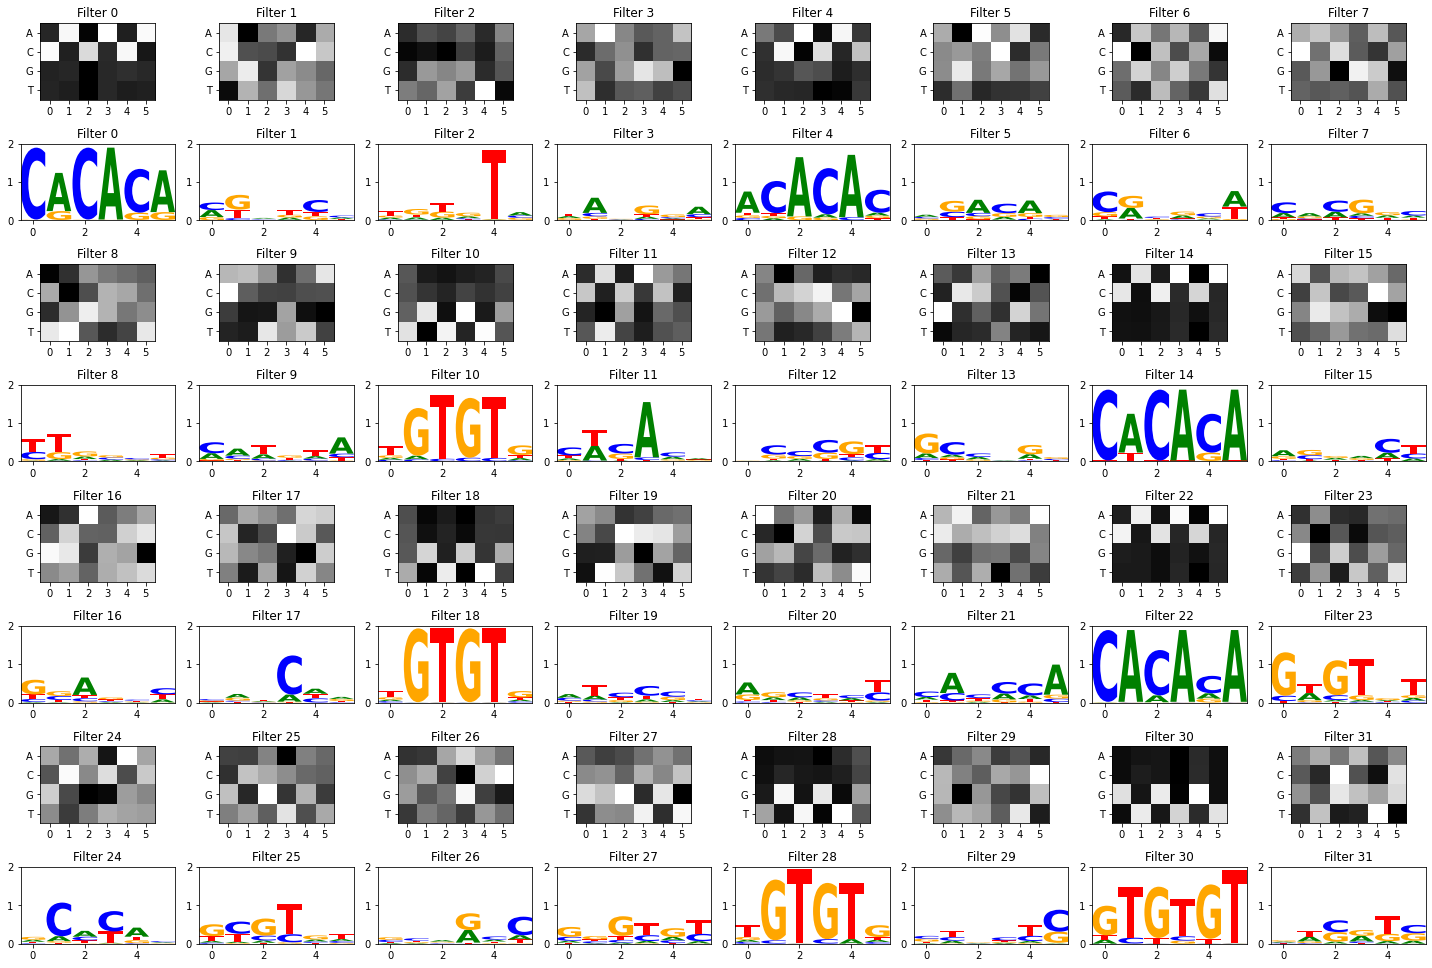

In [45]:
view_filters_and_logos(model_weights,filter_activations,ysc=0.75)

## Old tinkering

In [46]:
w = torch.tensor([10.0,100.0,1.0])
cel = nn.CrossEntropyLoss()
celw = nn.CrossEntropyLoss(weight=w)

In [48]:
a = torch.tensor([[1.0,2.0,3.0],
                  [1.0,3.0,2.0],
                  [3.0,1.0,2.0]])

b = torch.tensor([2,1,2])
c = torch.tensor([0,1,2])

print('normal')
print(cel(a,b))
print(cel(a,c))
print()
print('weighted')
print(celw(a,b))
print(celw(a,c))

normal
tensor(0.7409)
tensor(1.4076)

weighted
tensor(0.4174)
tensor(0.5968)


In [45]:
print(a.shape)
print(b.shape)

torch.Size([2, 3])
torch.Size([2])


In [104]:
seqs = train_df['locus_tag'].values #val_df['locus_tag'].values

p = quick_classify(mer8motif_model_cnn,seqs,oracle_syn)

EQU24_RS06320: pred:2 actual:0
EQU24_RS06320: pred:2 actual:0 ([6.231020450592041, -6.871827602386475, 6.793558597564697])
EQU24_RS06855: pred:1 actual:0
EQU24_RS06855: pred:1 actual:0 ([5.818170547485352, 6.306614875793457, -5.028451919555664])
EQU24_RS16240: pred:1 actual:0
EQU24_RS16240: pred:1 actual:0 ([6.875643253326416, 7.228374004364014, -6.141620635986328])


In [93]:
p.tolist()[0]

[6.06266975402832, 2.4189703464508057, -2.8052988052368164]

In [67]:
genes = train_df['locus_tag'].values
seqs = [torch.tensor(u.one_hot_encode(loc2seq[x])).unsqueeze(0).to(DEVICE).float() for x in genes]

preds = mer8motif_model_cnn(torch.stack(seqs).squeeze(1))

In [85]:
preds

tensor([[9.9989e-01, 1.0368e-04, 8.5303e-06],
        [9.9997e-01, 2.7287e-05, 2.8173e-06],
        [9.8730e-01, 5.0449e-05, 1.2647e-02],
        ...,
        [9.9740e-01, 1.9590e-05, 2.5840e-03],
        [9.9967e-01, 2.5071e-04, 8.1230e-05],
        [9.9950e-01, 4.3107e-04, 6.7942e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)

In [85]:
val_df.value_counts('reg')

reg
0    334
2     11
1      8
dtype: int64

In [110]:
genes_with_motifs = ['EQU24_RS00275','EQU24_RS01000','EQU24_RS01145','EQU24_RS01350','EQU24_RS01510','EQU24_RS01840','EQU24_RS01895','EQU24_RS01900','EQU24_RS02065','EQU24_RS02090','EQU24_RS02305','EQU24_RS02735','EQU24_RS02990','EQU24_RS03550','EQU24_RS03555','EQU24_RS03610','EQU24_RS04575','EQU24_RS04690','EQU24_RS05030','EQU24_RS05090','EQU24_RS05095','EQU24_RS05810','EQU24_RS05885','EQU24_RS06285','EQU24_RS06410','EQU24_RS06960','EQU24_RS07465','EQU24_RS07825','EQU24_RS08030','EQU24_RS08830','EQU24_RS08840','EQU24_RS08860','EQU24_RS08880','EQU24_RS09300','EQU24_RS09730','EQU24_RS09760','EQU24_RS09900','EQU24_RS10145','EQU24_RS10685','EQU24_RS10700','EQU24_RS10745','EQU24_RS12075','EQU24_RS12370','EQU24_RS12810','EQU24_RS13170','EQU24_RS13370','EQU24_RS13465','EQU24_RS14795','EQU24_RS14835','EQU24_RS15280','EQU24_RS15800','EQU24_RS15850','EQU24_RS16395','EQU24_RS16400','EQU24_RS16545','EQU24_RS16935','EQU24_RS17340','EQU24_RS17960','EQU24_RS18175','EQU24_RS18350','EQU24_RS18600','EQU24_RS18860','EQU24_RS19095','EQU24_RS19160','EQU24_RS19290','EQU24_RS19580','EQU24_RS20100','EQU24_RS20210','EQU24_RS20225','EQU24_RS20485','EQU24_RS20940','EQU24_RS21145','EQU24_RS21675','EQU24_RS21805','EQU24_RS21815']
seqs_with_motifs = [loc2seq[x] for x in genes_with_motifs]
seqs_with_motifs = [torch.tensor(u.one_hot_encode(seq)).unsqueeze(0).to(DEVICE).float() for seq in seqs_with_motifs]
preds = mer8motif_model_cnn(torch.stack(seqs_with_motifs).squeeze(1))

In [113]:
quick_classify(mer8motif_model_cnn,genes_with_motifs,oracle_syn)

done
